<a href="https://colab.research.google.com/github/ChristianaZorzi/DSC511-Group-Project-Final/blob/main/DSC511_GroupProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSC 511 - Big Data Analytics - Group Semester Project
## Reviews of restaurants for pre and post-Covid-19 periods
### Spring Semester 2025
##### Team: Rafaela Christou, Emili Rousou, Christiana Zorzi, Vasiliki Christodoulou

The dataset used for this project was sourced from Kaggle and includes two CSV files containing restaurant reviews from pre-COVID and post-COVID periods, allowing for comparative analysis of customer sentiment and behaviour over time.
Through this analysis, we aim to understand how user behavior and sentiment changed due to the impact of COVID-19 on the restaurant industry.

We tried to answer questions like:

- How did the customer sentiment change over time (post and pre covid)?


- How did the total number of reviews per restaurant change from the pre-COVID period to the post-COVID period?


- Did the average customer star ratings for the top 15 highest-rated restaurants decline after COVID-19, and if so, which restaurants were most affected?


- Which U.S. states had the highest number of restaurants pre-COVID vs. post-COVID?

- Which states had the highest number of restaurant reviews in the pre-COVID and post-COVID periods? Did the top states in number of reviews change over time?

- How accuraately the classification model (logistic regression) is predicting the sentiment of the customers reviews?

- Finding the topics of the reviews pre and post Covid.


## Loading libraries

In [ ]:
# Installing pyspark
! pip3 install pyspark

In [ ]:
# Importing Libraries
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
from google.colab import drive
from pyspark.sql.window import Window
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDF
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.types import MapType, StringType
import plotly.express as px
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import datetime
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

Creating the Spark Session

In [ ]:
spark = SparkSession.builder \
    .appName("Group_Project_Reviews_Covid") \
    .master("local") \
    .getOrCreate()

## Loading the datasets

In [ ]:
# Google drive and reading the csv of post dataset
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/postcovid_reviews.csv"

Mounted at /content/gdrive


In [ ]:
# Google drive and reading the csv of pre dataset
drive.mount('/content/gdrive')
google_drive = "/content/gdrive/MyDrive/precovid_reviews.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
post_df = spark.read.parquet("/content/gdrive/MyDrive/post_parquet")

In [ ]:
post_df.show(10)

+--------------------+--------------------+--------------------+------+------------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|state_|        city|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+------+------------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|2WRCcQATOe_Em0k61...|Yook Korean Grill...| 2408 Nanaimo Street|   

In [ ]:
pre_df = spark.read.parquet("/content/gdrive/MyDrive/pre_parquet")

In [ ]:
pre_df.show(10)

+--------------------+--------------------+--------------------+------+---------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|state_|     city|postal_code|          latitude|          longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+------+---------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|EXOsmAB1s71WePlQk...|Linwood Grill & B...|   

## Data Preprocessing

Checking for missing values


In [ ]:
# check for missing values
pre_df = pre_df.replace("NULL", None)
pre_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in pre_df.columns]).show()

+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+------+---------+-------+--------------+------+-----+----+-----+-----+
|business_id|name|address|state_|city|postal_code|latitude|longitude|stars|review_count|is_open|categories| hours|review_id|user_id|customer_stars|useful|funny|cool|text_|date_|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+------+---------+-------+--------------+------+-----+----+-----+-----+
|          0|   0|  13409|     0|   0|        384|       0|        0|    0|           0|      0|         0|216501|        0|      0|             0|     0|    0|   0|    1|    0|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+------+---------+-------+--------------+------+-----+----+-----+-----+



In [ ]:
# check for missing values
post_df = post_df.replace("NULL", None)
post_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in post_df.columns]).show()

+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+
|business_id|name|address|state_|city|postal_code|latitude|longitude|stars|review_count|is_open|categories|hours|review_id|user_id|customer_stars|useful|funny|cool|text_|date_|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+
|          0|   0|    992|     0|   0|          4|       0|        0|    0|           0|      0|         0|12232|        0|      0|             0|     0|    0|   0|    0|    0|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+



Both datasets have some missing values in address,hours and postal code columns.
Since we will mostly focus on the reviews we decided to not drop them.
Only the one missing review was removed.

In [ ]:
pre_df = pre_df.dropna(subset=["text_"])

Removing duplicated reviews

In [ ]:
# Checking for duplicated values
print(pre_df.count())
pre_df = pre_df.dropDuplicates()
print(pre_df.count())
# there are no duplicated rows

5172197
5172197


In [ ]:
# Checking for duplicated values
print(post_df.count())
post_df = post_df.dropDuplicates()
print(post_df.count())
# there are no duplicated rows

400295
400295


Removing identical reviews made from the same user about a specific business

In [ ]:
# Drop duplicate reviews (same user, business, and text)
post_df = post_df.dropDuplicates(["user_id", "business_id", "text_"])
post_df.count()
# Number of rows before removing duplicated reviews: 400295

399826

In [ ]:
# Drop duplicate reviews (same user, business, and text)
pre_df = pre_df.dropDuplicates(["user_id", "business_id", "text_"])
pre_df.count()
# Number of rows before removing duplicated reviews: 5172198

5163366

Date Range of Post and Pre Covid dataset

In [ ]:
print('Date Range Pre-Covid:', pre_df.select(min('date_')).collect()[0][0], '-', pre_df.select(max('date_')).collect()[0][0])
print('Date Range Post-Covid:', post_df.select(min('date_')).collect()[0][0], '-', post_df.select(max('date_')).collect()[0][0])

Date Range Pre-Covid: 2004-10-13 00:03:20 - 2019-12-30 23:59:16
Date Range Post-Covid: 2020-01-01 00:00:01 - 2021-01-27 23:59:54


 The first American case was reported on January 20, and Health and Human Services Secretary Alex Azar declared a public health emergency on January 31.
 https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States

Finding reviews before covid started in USA

In [ ]:
pre_covid_reviews = post_df.filter(col("date_")< to_timestamp(lit("2020-01-20 00:00:01")))
pre_covid_reviews.count()

31633

 There are 31633 reviews that were written before 20/01,which was when the first covid case was reported in America

Removing those reviews from the post covid dataset

In [ ]:
post_df =post_df.filter(col("date_") >= to_timestamp(lit("2020-01-20 00:00:01")))
post_df.count()

368193

Adding those reviews in the pre covid dataset

In [ ]:
pre_df = pre_df.union(pre_covid_reviews)
pre_df.show()

+--------------------+--------------------+--------------------+------+----------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|state_|      city|postal_code|          latitude|          longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+------+----------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|WwUkt_i82xhQASXP8...|          Seasons 52|

Checking if each business id has a unique name

In [ ]:
print('unique names:', pre_df.select("name").distinct().count())
print('unique ids:', pre_df.select('business_id').distinct().count())

unique names: 36260
unique ids: 49404


In [ ]:
print('unique names:', post_df.select("name").distinct().count())
print('unique ids:', post_df.select('business_id').distinct().count())

unique names: 21595
unique ids: 30061


#### Location

##### Location - Preprocessing - Post df

In [ ]:
# Printing unique Cities
post_df.select(col("city")).distinct().count()

392

As we can notice at first the post covid dataset contained 392 distinct cities, but with a detailed inspection we observed that there was similar cities just written differentlty.

In [ ]:
# Let's clean and normalize city column
# Converting the first letters to capital ones and by using trim we remove
# extra spaces
# initcamp convert the column to title case, where the first letter is always capital
post_df=post_df.withColumn("city",initcap(trim(col("city"))))
post_df.show()

+--------------------+--------------------+--------------------+------+-------------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|state_|         city|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+------+-------------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|X3i217AeA8VBkf7ar...|Popeyes Louisiana...|20295 SW Tualatin.

In [ ]:
post_df.select(col("city")).distinct().count()

358

We can notice that the unique cities
are reduced to 358.

In [ ]:
# Removing any punctuations and extra spaces for comparison
# e.g. St.Cloud now will be stcloud
post_df = post_df.withColumn("city_key", lower(regexp_replace(col("city"), r"[^a-zA-Z0-9]", "")))

In [ ]:
# Let's see how many cities we have with the same key
post_df.groupBy("city_key", "city").count().orderBy("city_key").show(360, truncate=False)

+---------------------+-----------------------+-----+
|city_key             |city                   |count|
+---------------------+-----------------------+-----+
|acworth              |Acworth                |2    |
|alafaya              |Alafaya                |79   |
|alamontesprings      |Alamonte Springs       |7    |
|allston              |Allston                |991  |
|aloha                |Aloha                  |304  |
|aloma                |Aloma                  |19   |
|altamontesprings     |Altamonte Springs      |1748 |
|andover              |Andover                |12   |
|apopka               |Apopka                 |702  |
|arlington            |Arlington              |590  |
|arvada               |Arvada                 |2    |
|ashville             |Ashville               |14   |
|atlanta              |Atlanta                |44402|
|auburndale           |Auburndale             |18   |
|austell              |Austell                |1    |
|austin               |Austi

In [ ]:
# Creating window to rank cities by count per city_key
# For each group of rows with the same city_key sort them by how often they appear
# By using window we create a subset of dataframe where all rows have the same key
# and within each window rows are ordered by the count in descending order
windowSpec = Window.partitionBy("city_key").orderBy(col("count").desc())

# Counting how many times city name appears per city
city_counts = post_df.groupBy("city_key", "city").count()

# Picking the most common city_clean for each city_key
standard_cities = city_counts.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") == 1)

### Now we have a standarized column, e.g. stcloud-> St. Cloud
#### we don't have multiple variations like stcloud, St.  Cloud and St.CLoud etc

###### Explanation of window
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Window.html


Break data into groups based on city key (all rows same city key are groupped together).

In [ ]:
# Renaming the selected column
standard_cities = standard_cities.withColumnRenamed("city", "city_standardized")

# Preforming join to have a final dataframe
post_df = post_df.join(
    standard_cities.select("city_key", "city_standardized"),
    on="city_key",
    how="left"
)

In [ ]:
# Dropping city key and city columns, because they are not useful
post_df=post_df.drop("city_key", "city")

In [ ]:
post_df.show()

+--------------------+--------------------+--------------------+------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+-----------------+
|         business_id|                name|             address|state_|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|city_standardized|
+--------------------+--------------------+--------------------+------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+-----------------+
|2V_HCjysh3FxDjcDs...|      One Eared Stag|1029 E

In [ ]:
post_df.select("city_standardized").distinct().count()

349

The final unique cities  of our dataset
are 349.

##### Location - Preprocessing - Pre df

In [ ]:
# Finding the unique cities
pre_df.select(col("city")).distinct().count()

450

At a first sight in the pre covid dataset we have a total of 450 cities.
But lets check like before.

Same approach we used in post covid dataframe.

In [ ]:
# Let's clean and normalize city column
# Converting the first letters to capital ones and by using trim we remove
# extra spaces
pre_df=pre_df.withColumn("city",initcap(trim(col("city"))))
pre_df.show()

+--------------------+--------------------+--------------------+------+----------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|state_|      city|postal_code|          latitude|          longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+------+----------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|WwUkt_i82xhQASXP8...|          Seasons 52|

In [ ]:
# Finding the unique cities
pre_df.select(col("city")).distinct().count()

415

As we expected the unique cities are reduced. Now we have a total of 415.

In [ ]:
# Removing any punctuations and extra spaces for comparison
# e.g. St.Cloud now will be stcloud or St.  Cloud and St. Cloud are treated
# as two distincts cities

pre_df = pre_df.withColumn("city_key", lower(regexp_replace(col("city"), r"[^a-zA-Z0-9]", "")))

In [ ]:
# Let's see how many cities we have with the same key
pre_df.groupBy("city_key", "city").count().orderBy("city_key").show(360, truncate=False)

+-----------------------+-------------------------+------+
|city_key               |city                     |count |
+-----------------------+-------------------------+------+
|acworth                |Acworth                  |12    |
|alafaya                |Alafaya                  |56    |
|alamontesprings        |Alamonte Springs         |113   |
|allston                |Allston                  |29122 |
|aloha                  |Aloha                    |3141  |
|alpharetta             |Alpharetta               |157   |
|altamontesprings       |Altamonte Springs        |16661 |
|altamontespringsorlando|Altamonte Springs Orlando|210   |
|andover                |Andover                  |202   |
|apopka                 |Apopka                   |5538  |
|arlington              |Arlington                |12325 |
|arvada                 |Arvada                   |16    |
|ashville               |Ashville                 |46    |
|atlanta                |Atlanta                  |55476

In [ ]:
# Creating window to rank cities by count per city_key
# For each group of rows with the same city_key sort them by how often they appear
windowSpec = Window.partitionBy("city_key").orderBy(col("count").desc())

# Counting how many times city name appears per city
city_counts = pre_df.groupBy("city_key", "city").count()

# Picking the most common city_clean for each city_key
standard_cities = city_counts.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") == 1)

### Now we have a standarized column, e.g. stcloud-> St. Cloud

In [ ]:
# Renaming the selected column
standard_cities = standard_cities.withColumnRenamed("city", "city_standardized")

# Preforming join to have a final dataframe
pre_df = pre_df.join(
    standard_cities.select("city_key", "city_standardized"),
    on="city_key",
    how="left"
)


In [ ]:
# Dropping city key and city columns, because they are not useful
pre_df=pre_df.drop("city_key", "city")

In [ ]:
pre_df.select("city_standardized").distinct().count()

404

The final total number of cities in the pre covid dataframe is 404.

#### State

##### State - Post df

In [ ]:
# Finding the unique states
post_df.select(col("state_")).distinct().count()

14

ABE is not a regognized USA state so let's investigate further.

In [ ]:
# Finding rows with ABE state
post_df.filter(col("state_")=="ABE").count()

3

In [ ]:
# Displaying the details for those 3 rows
post_df.filter(col("state_") == "ABE") \
    .select("name", "address", "city_standardized", "postal_code", "latitude", "longitude") \
    .show(truncate=False)

+-------------------+------------------+-----------------+-----------+--------+-----------+
|name               |address           |city_standardized|postal_code|latitude|longitude  |
+-------------------+------------------+-----------------+-----------+--------+-----------+
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
+-------------------+------------------+-----------------+-----------+--------+-----------+



There is no state called ABE. Actually, the above restauraunts are in the Vancouver, British Columbia, Canada, so the correct province is BC.

In [ ]:
# Changing to the correct province
post_df=post_df.withColumn("state_",
                          when((col("state_") == "ABE") & (col("city_standardized") == "Vancouver"), "BC")
    .otherwise(col("state_"))
)

In [ ]:
# Checking if the changes are applied
post_df.filter(col("state_")=="ABE").count()

0

In [ ]:
post_df.select("state_").distinct().count()

13

In [ ]:
post_df.select("state_").distinct().show()

+------+
|state_|
+------+
|    OR|
|    VA|
|    WY|
|    KY|
|    BC|
|    NH|
|    WA|
|    OH|
|    TX|
|    GA|
|    MA|
|    FL|
|    CO|
+------+



In conclusion in the post covid dataset we have a total of  13  unique states.

##### State - Pre df

In [ ]:
# Finding the unique states
pre_df.select(col("state_")).distinct().count()

16

The pre covid dataset contains 16 states.
But let's check it like before.

In [ ]:
# Printing Unique States
pre_df.select(col("state_")).distinct().show()

+------+
|state_|
+------+
|    OR|
|    WY|
|    BC|
|    WA|
|    OH|
|    TX|
|    GA|
|    MA|
|    KS|
|    FL|
|    CO|
|    VA|
|    NH|
|    MN|
|    KY|
|   ABE|
+------+



Keeping the same approach with pre covid dataset.

In [ ]:
# Finding rows with ABE state
pre_df.filter(col("state_")=="ABE").count()

11

In [ ]:
# Displaying the details for those 11 rows
pre_df.filter(col("state_") == "ABE") \
    .select("name", "address", "city_standardized", "postal_code", "latitude", "longitude") \
    .show(truncate=False)

+-------------------+------------------+-----------------+-----------+--------+-----------+
|name               |address           |city_standardized|postal_code|latitude|longitude  |
+-------------------+------------------+-----------------+-----------+--------+-----------+
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-123.133761|
|Kitanoya Guu Garlic|1698 Robson Street|Vancouver        |V6G 1C7    |49.29065|-

In [ ]:
# Changing to the correct province
pre_df=pre_df.withColumn("state_",
                          when((col("state_") == "ABE") & (col("city_standardized") == "Vancouver"), "BC")
    .otherwise(col("state_"))
)

In [ ]:
# Checking if the changes are applied
pre_df.filter(col("state_")=="ABE").count()

0

In [ ]:
pre_df.select("state_").distinct().count()

15

In [ ]:
pre_df.select(col("state_")).distinct().show()

+------+
|state_|
+------+
|    MN|
|    OR|
|    VA|
|    WY|
|    KY|
|    BC|
|    NH|
|    WA|
|    OH|
|    TX|
|    GA|
|    MA|
|    KS|
|    FL|
|    CO|
+------+



In conclusion we have 15 unique states in the pre dataset.

### Hours column

In [ ]:
post_df.select("hours").printSchema()

root
 |-- hours: string (nullable = true)



In [ ]:
# convert the hours column into dictionary
# Define the schema for the 'hours' column as a Map[String, String]
schema = MapType(StringType(), StringType())

# Convert the 'hours' column from string to a MapType
post_df = post_df.withColumn("hours", from_json(post_df["hours"], schema))

# Verify the schema
post_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: timestamp (nullable = true)
 |-- city_standardized: string (nullable = true)



Count how many businesses have null hours for all days of the week.

In [ ]:
## Find records with null values in the hours column or where all days have null values

from pyspark.sql.functions import col, size, map_values

# Filter rows where 'hours' is null or where all values in the 'hours' map are null
df_filtered = post_df.filter(
    (col('hours').isNull()) |  # Check if the 'hours' column is null
    ((size(map_values(col('hours'))) > 0) &  # Check if the map has any entries
     (col('hours').getItem('Monday').isNull() &
      col('hours').getItem('Tuesday').isNull() &
      col('hours').getItem('Wednesday').isNull() &
      col('hours').getItem('Thursday').isNull() &
      col('hours').getItem('Friday').isNull() &
      col('hours').getItem('Saturday').isNull() &
      col('hours').getItem('Sunday').isNull())
    )
)

df_filtered.count()

11327

Define periods:
- Morning: 06:00-12:00
- Afternoon: 12:00-17:00
- Evening: 17:00 -23:00
- LateNight: 23:00- 06:00

In [ ]:
# Define a UDF to categorize the period based on opening and closing times
def categorize_period(opening_closing_str):
    try:
        opening, closing = opening_closing_str.split('-')
        opening_hour, opening_minute = map(int, opening.split(':'))
        closing_hour, closing_minute = map(int, closing.split(':'))

        # Combine the time into a datetime object for comparison
        opening_time = datetime.time(opening_hour, opening_minute)
        closing_time = datetime.time(closing_hour, closing_minute)

        # Define time ranges (assuming the times are in the format "HH:MM")
        if opening_time >= datetime.time(6, 0) and closing_time <= datetime.time(12, 0):
            return 'Morning'
        elif opening_time >= datetime.time(12, 0) and closing_time <= datetime.time(17, 0):
            return 'Afternoon'
        elif opening_time >= datetime.time(17, 0) and closing_time <= datetime.time(23, 0):
            return 'Evening'
        elif closing_time >= datetime.time(23, 0) or opening_time <= datetime.time(6, 0):
            return 'Late Night'
        else:
            return 'Unknown'
    except Exception as e:
        return 'Closed'

# Register UDF with Spark
categorize_period_udf = udf(categorize_period, StringType())

# Add new column 'period' by applying the UDF on each day in the 'hours' map
df_with_period = post_df.withColumn(
    'period_Monday',
    categorize_period_udf(col('hours').getItem('Monday'))  # Example for Monday, repeat for other days if needed
)

df_with_period.show(truncate=False)

+----------------------+--------------------------------+-------------------------------+------+-----------+-------------+---------------+-----+------------+-------+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------+--------------+------+-----+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_with_period = df_with_period.withColumn(
    'period_Tuesday',
    categorize_period_udf(col('hours').getItem('Tuesday'))
)
df_with_period = df_with_period.withColumn(
    'period_Wednesday',
    categorize_period_udf(col('hours').getItem('Wednesday'))
)
df_with_period = df_with_period.withColumn(
    'period_Thursday',
    categorize_period_udf(col('hours').getItem('Thursday'))
)
df_with_period = df_with_period.withColumn(
    'period_Friday',
    categorize_period_udf(col('hours').getItem('Friday'))
)
df_with_period = df_with_period.withColumn(
    'period_Saturday',
    categorize_period_udf(col('hours').getItem('Saturday'))
)
df_with_period = df_with_period.withColumn(
    'period_Sunday',
    categorize_period_udf(col('hours').getItem('Sunday'))
)

In [ ]:
# Select only columns whose name contains the word 'period'
df_with_period.select([col(column) for column in df_with_period.columns if 'period' in column.lower()]).show(truncate=False)

+-------------+--------------+----------------+---------------+-------------+---------------+-------------+
|period_Monday|period_Tuesday|period_Wednesday|period_Thursday|period_Friday|period_Saturday|period_Sunday|
+-------------+--------------+----------------+---------------+-------------+---------------+-------------+
|Evening      |Evening       |Evening         |Evening        |Evening      |Evening        |Evening      |
|Closed       |Closed        |Unknown         |Unknown        |Unknown      |Unknown        |Unknown      |
|Unknown      |Unknown       |Unknown         |Unknown        |Unknown      |Unknown        |Unknown      |
|Late Night   |Unknown       |Unknown         |Unknown        |Unknown      |Unknown        |Unknown      |
|Late Night   |Late Night    |Late Night      |Late Night     |Late Night   |Late Night     |Late Night   |
|Evening      |Evening       |Evening         |Evening        |Evening      |Evening        |Evening      |
|Late Night   |Late Night   

# Exploratory Data Analysis

## Post - Covid Analysis

#### State EDA

<ipython-input-72-156229eb5aec>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(top, x="state_", y="business_count", alpha=0.8, palette="summer")


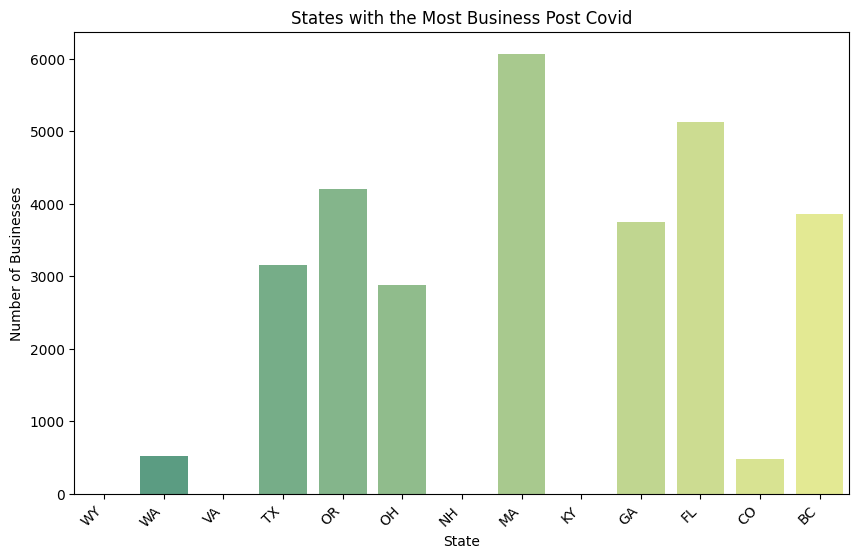

In [ ]:
# Number of Business in Each State
# Counting the business in each state
state_counts=post_df.groupBy("state_").agg(countDistinct("business_id").alias("business_count")).orderBy("state_", ascending=False)
# Top 10 Cities with the most business
top=state_counts.toPandas()

#Plotting
plt.figure(figsize=(10,6))
sns.barplot(top, x="state_", y="business_count", alpha=0.8, palette="summer")

# Setting title and labels
plt.title("States with the Most Business Post Covid")
plt.xlabel("State")
plt.ylabel("Number of Businesses")

# Rotating and displaying the plot
plt.xticks(rotation=45, ha='right')
plt.show()

Florida, Massachusetts, Oregon and Georgia have the most restauraunts, post covid.

In [ ]:
#Total number of reviews for each business in each state
state_reviews=post_df.groupBy("state_", "business_id").agg(sum("review_count").alias("review_count")).orderBy("review_count", ascending=False)

<ipython-input-74-3a636a4332ae>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(state_reviews_pd, x="state_", y="review_count", alpha=0.8, palette="summer")


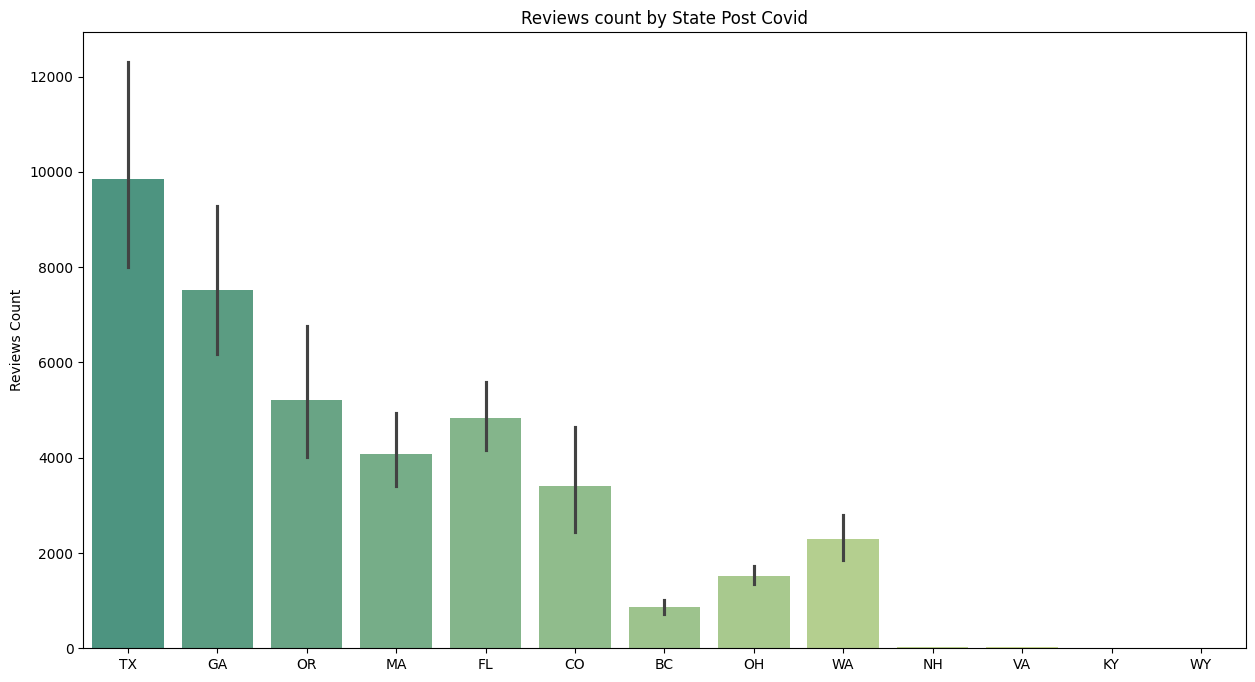

In [ ]:
# Converting to pandas
state_reviews_pd = state_reviews.toPandas()

# Plotting the bar plot
plt.figure(figsize=(15,8))
sns.barplot(state_reviews_pd, x="state_", y="review_count", alpha=0.8, palette="summer")
plt.xlabel("")
plt.ylabel("Reviews Count")
plt.title("Reviews count by State Post Covid")

# Displaying the plot
plt.show()

The top reviewed states in terms of businesses are Texas, Georgia, Oregon and Florida.

#### City EDA

<ipython-input-75-2315f21d916c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(top_cities, x="city_standardized", y="count", alpha=0.8, palette="summer")


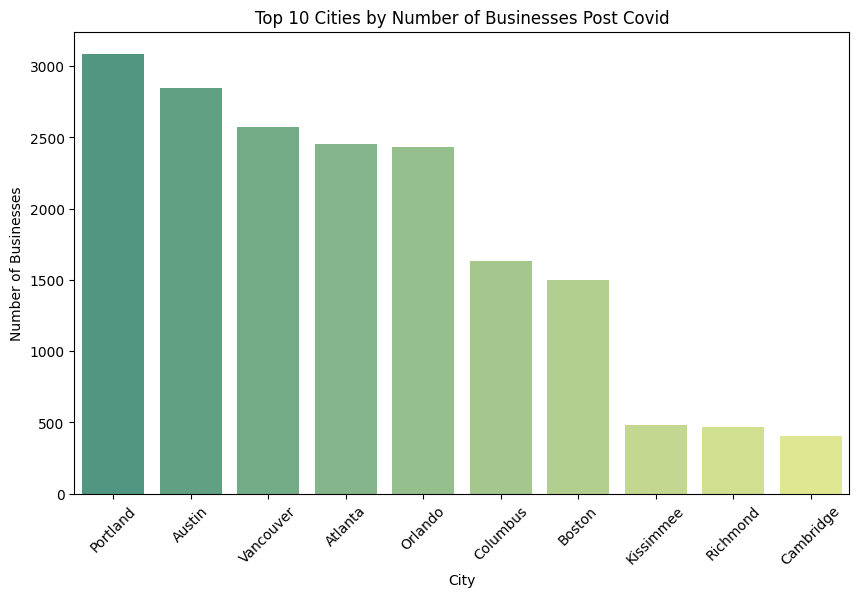

In [ ]:
# Plotting the top 10 cities based on number of business

# Converting post df to pandas
city_counts=post_df.groupBy("city_standardized").agg(countDistinct("business_id").alias("count")).orderBy(col("count"),ascending = False).limit(10)

# Sorting and plotting the top 10
top_cities= city_counts.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(top_cities, x="city_standardized", y="count", alpha=0.8, palette="summer")
plt.xticks(rotation=45)

# Setting the labels and the title
plt.title("Top 10 Cities by Number of Businesses Post Covid")
plt.xlabel("City")
plt.ylabel("Number of Businesses")

# Displaying the plot
plt.show()

The city that contains the most business in the post covid dataset is
Portland, Austin, followed by Vancouver and Atlanta.

### Stars EDA

<ipython-input-77-2c16a9015f0c>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




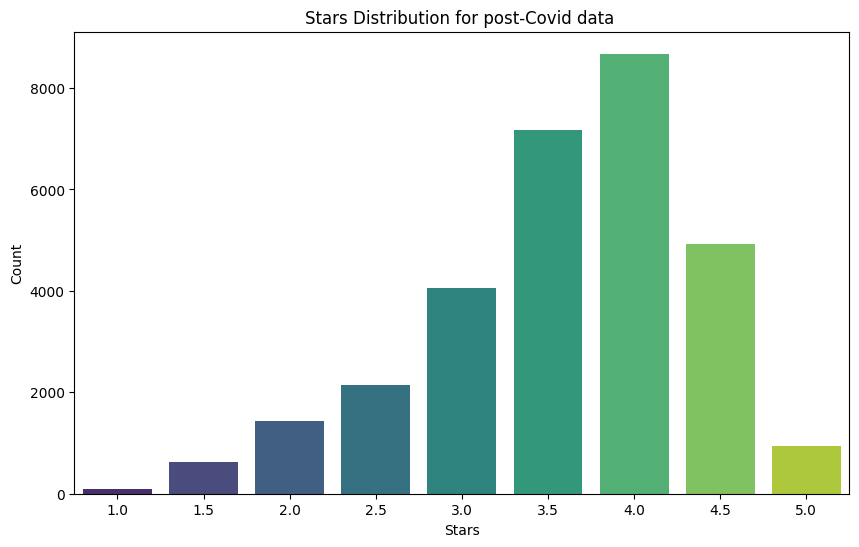

In [ ]:
# Convert the DataFrame to a Pandas DataFrame
df_stars_post=post_df.groupBy("stars",'business_id').agg(countDistinct('business_id').alias("count")).toPandas()

plt.figure(figsize=(10,6))

# Plot : Distribution of stars from post_df
sns.countplot(x='stars', data=df_stars_post, palette='viridis',
              order=sorted(df_stars_post['stars'].dropna().unique()))
plt.title("Stars Distribution for post-Covid data ")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

Most restauraunts are rated on post-COVID period, around 4 stars, with a clear drop in 5-star reviews, indicating generally positive but more moderate satisfaction.

### Open or Closed EDA

<ipython-input-78-1fca262d6bfb>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




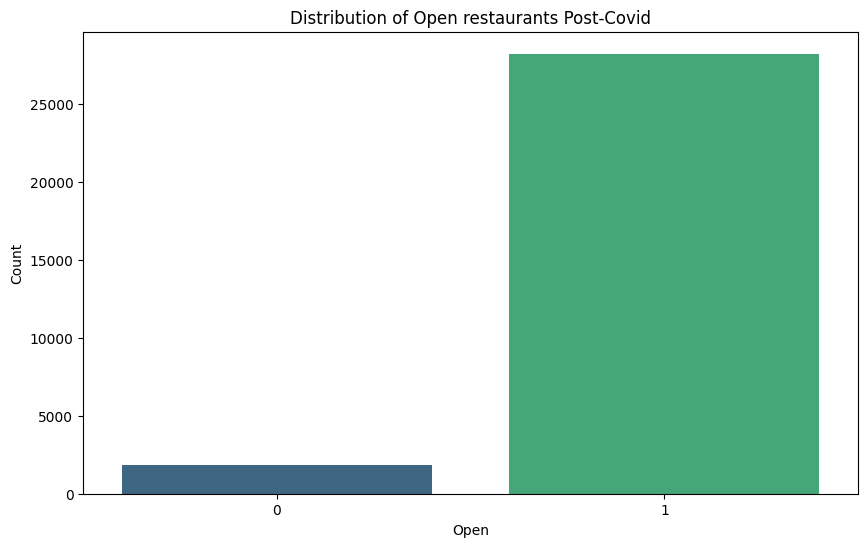

In [ ]:
count_closed_post = post_df.groupBy("is_open").agg(countDistinct('business_id').alias("count"))
plt.figure(figsize=(10,6))
sns.barplot(x="is_open",y="count",data=count_closed_post.toPandas(),palette="viridis")
# Add labels and title
plt.xlabel("Open")
plt.ylabel("Count")
plt.title("Distribution of Open restaurants Post-Covid")
plt.show()

From the above barplot we can clearly notice the vast majority of restaurants remained open post-COVID, while only a small portion closed.

### Customer stars EDA

<ipython-input-79-c92165a06379>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




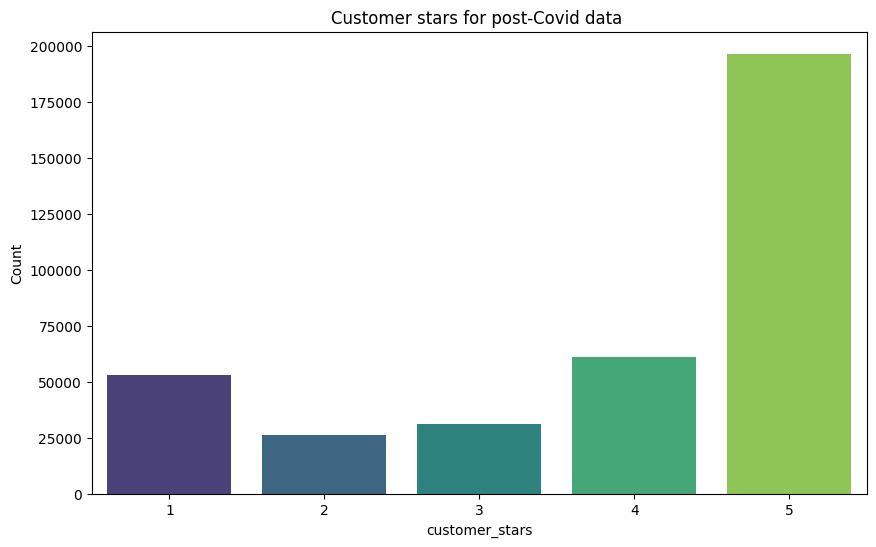

In [ ]:
df_stars_post = post_df.select('customer_stars').toPandas()

plt.figure(figsize=(10,6))

# Plot : Distribution of stars from post_df
sns.countplot(x='customer_stars', data=df_stars_post, palette='viridis',
              order=sorted(df_stars_post['customer_stars'].dropna().unique()))
plt.title("Customer stars for post-Covid data ")
plt.xlabel('customer_stars')
plt.ylabel("Count")
plt.show()

Post-COVID, customer feedback is seems to be positive with 5-star ratings dominating the dataset, though a noticeable number of 1-star reviews reveal a small porpotion of dissatisfaction.

### Useful EDA

<ipython-input-80-41ccca2cb92f>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




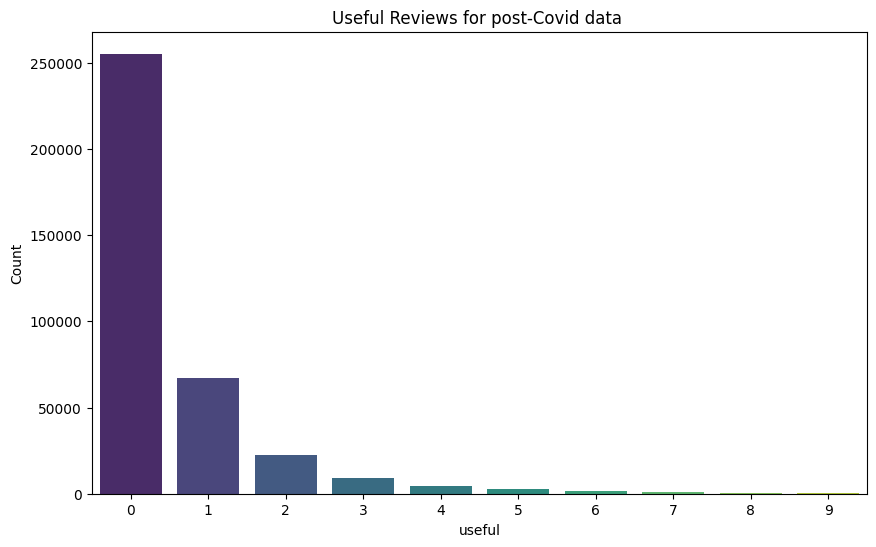

In [ ]:
# Filter for useful values between 0 and 10
df_useful_post = post_df.select('useful').filter(col("useful")<10).toPandas()

plt.figure(figsize=(10,6))
# Plot : Distribution of stars from post_df
sns.countplot(x='useful', data=df_useful_post, palette='viridis',
              order=sorted(df_useful_post['useful'].dropna().unique()))
plt.title("Useful Reviews for post-Covid data ")
plt.xlabel('useful')
plt.ylabel("Count")
plt.show()

### Funny EDA


<ipython-input-81-690f792d0ece>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




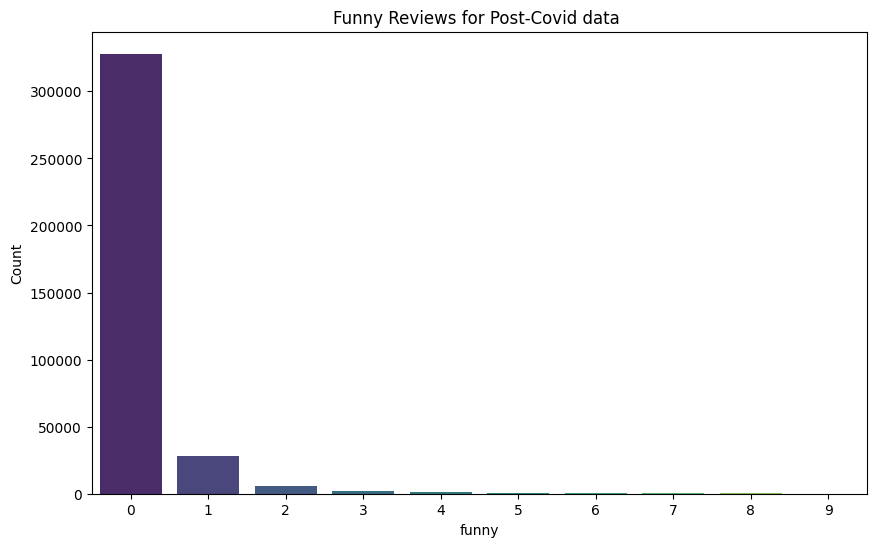

In [ ]:
# Filter for funny values between 0 and 10
df_funny_post = post_df.select('funny').filter(col("funny")<10).toPandas()

plt.figure(figsize=(10,6))
# Plot : Distribution of stars from post_df
sns.countplot(x='funny', data=df_funny_post, palette='viridis',
              order=sorted(df_funny_post['funny'].dropna().unique()))
plt.title("Funny Reviews for Post-Covid data ")
plt.xlabel('funny')
plt.ylabel("Count")
plt.show()

### Cool EDA

<ipython-input-82-7bf9717ee4ac>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




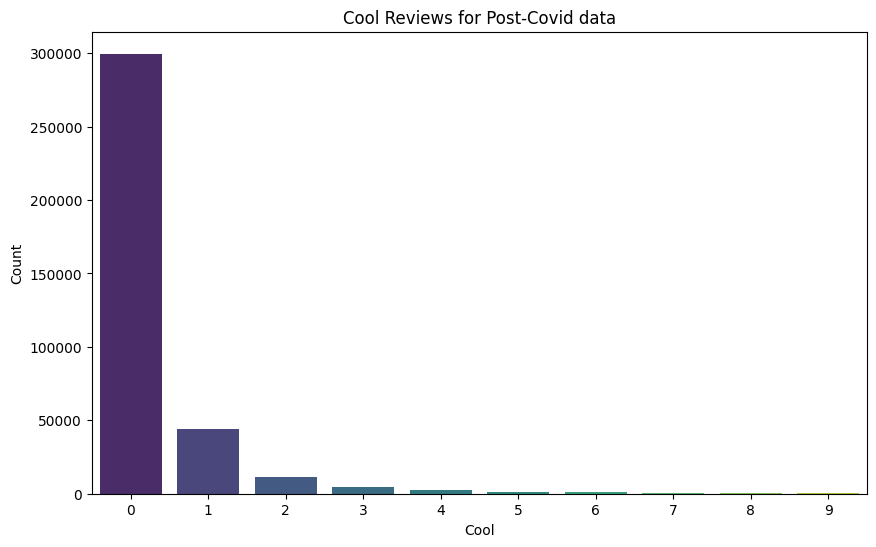

In [ ]:
df_cool_post = post_df.select('cool').filter(col("cool")<10).toPandas()

plt.figure(figsize=(10,6))

# Plot the distribution
sns.countplot(x='cool', data=df_cool_post, palette='viridis',
              order=sorted(df_cool_post['cool'].dropna().unique()))

# Set labels and title
plt.title("Cool Reviews for Post-Covid data")
plt.xlabel('Cool')
plt.ylabel("Count")
plt.show()

### Categories

Top 10 categories post covid with the most reviews

In [ ]:
post_df = post_df.withColumn("category", split(col("categories"), ","))
post_df.select(explode(col("category")).alias("category")).groupBy("category").count().sort("count",ascending = False,truncate=False).show(10)

+--------------------+------+
|            category| count|
+--------------------+------+
|         Restaurants|275527|
|                Food| 99889|
|         Restaurants| 92666|
|           Nightlife| 82886|
|                Bars| 82014|
|  Breakfast & Brunch| 50173|
| American (Tradit...| 49068|
|      American (New)| 45387|
|          Sandwiches| 38573|
|             Seafood| 31285|
+--------------------+------+
only showing top 10 rows



Removing leading whitespaces and lowercasing the categories

In [ ]:
# Trim and lowercase each item
def clean_category_list(cat_list):
    return [c.strip().lower() for c in cat_list if c]

clean_udf = udf(clean_category_list, ArrayType(StringType()))
post_df = post_df.withColumn("category", clean_udf(col("category")))

In [ ]:
post_df.select(explode(col("category")).alias("category")).distinct().count()

637

<ipython-input-152-a16dd77c929d>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




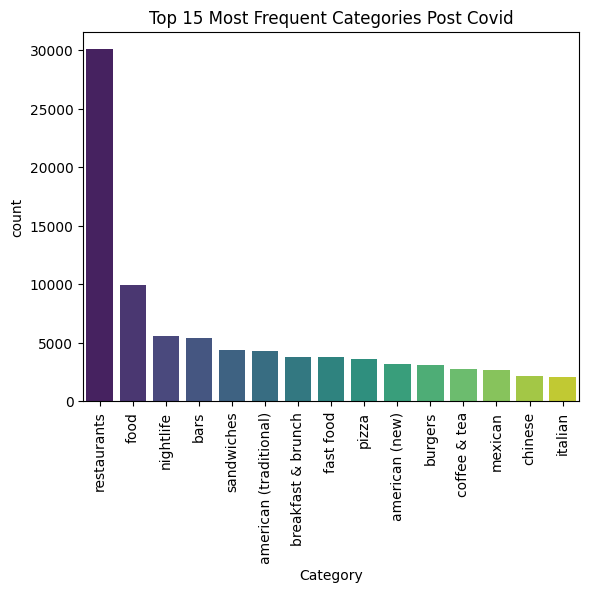

In [ ]:
top_categories_post = post_df.select(explode(col("category")).alias("category"),'business_id').groupBy("category").agg(countDistinct("business_id").alias("count")).orderBy("count", ascending=False)
top_categories = top_categories_post.limit(15)

#  Convert to pandas for plotting
pandas_df = top_categories.toPandas()

sns.barplot(x="category", y="count", data=pandas_df, palette = "viridis")
plt.title("Top 15 Most Frequent Categories Post Covid")
plt.xlabel("Category")
plt.xticks(rotation = 90)
plt.show()

In our dataset, the above bar plot reveals the top 15 categories post-COVID, with restaurants, food, nightlife, and bars clearly dominating in frequency.

<ipython-input-153-4948508d577c>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




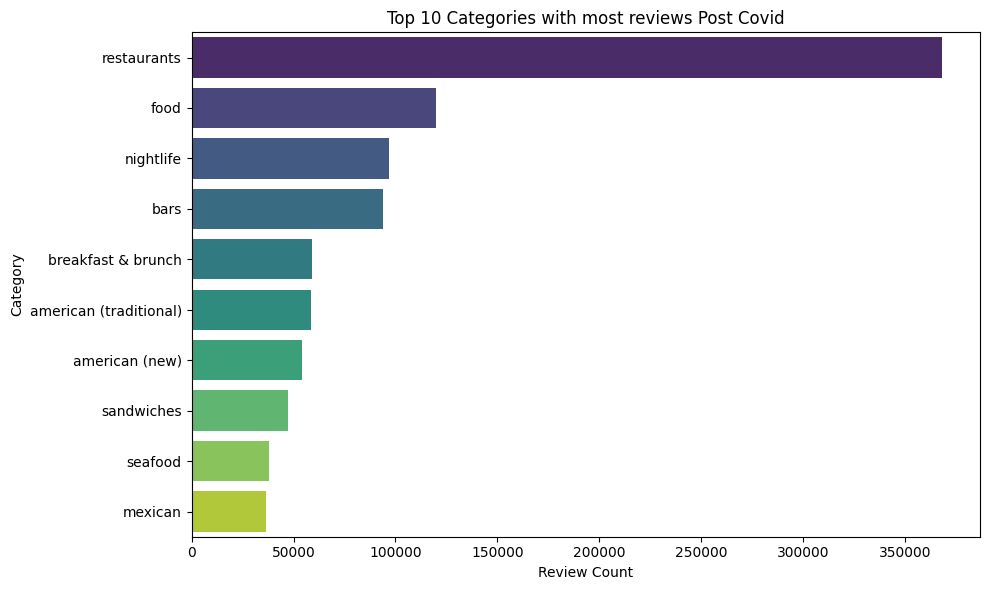

In [ ]:
top_categories_reviews = post_df.select(explode(col("category")).alias("category")) \
                        .groupBy("category") \
                        .count() \
                        .orderBy("count", ascending=False)

top_categories_pd_post = top_categories_reviews.limit(10).toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="count", y="category", data=top_categories_pd_post, palette="viridis")
plt.title("Top 10 Categories with most reviews Post Covid")
plt.xlabel("Review Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


Its noticeable from the above plot that post COVID, most reviews categories were restaurants, followed by food, nightlife, and bars.

In [ ]:
post_categories_df = post_df.withColumn("category", explode(split("categories", ", ")))
post_categories_df_negative = post_categories_df.filter(col("customer_stars")<3)
post_categories_df_negative.groupBy("category").agg(countDistinct("business_id").alias("count")).orderBy("count", ascending=False).show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|21692|
|                Food| 6734|
|           Nightlife| 4167|
|                Bars| 4035|
|American (Traditi...| 3348|
|           Fast Food| 3186|
|          Sandwiches| 3149|
|  Breakfast & Brunch| 2812|
|               Pizza| 2784|
|             Burgers| 2561|
|      American (New)| 2425|
|             Mexican| 2075|
|        Coffee & Tea| 1863|
|             Seafood| 1626|
|             Italian| 1623|
|             Chinese| 1581|
|               Salad| 1500|
|       Chicken Wings| 1355|
|            Japanese| 1271|
|Event Planning & ...| 1225|
+--------------------+-----+
only showing top 20 rows



In [ ]:
post_categories_df_positive = post_categories_df.filter(col("customer_stars") >= 3)
post_categories_df_positive.groupBy("category").agg(countDistinct("business_id").alias("count")).orderBy("count", ascending=False).show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|27314|
|                Food| 9067|
|           Nightlife| 5334|
|                Bars| 5155|
|American (Traditi...| 3983|
|          Sandwiches| 3904|
|  Breakfast & Brunch| 3529|
|               Pizza| 3219|
|      American (New)| 3052|
|           Fast Food| 2690|
|             Burgers| 2487|
|             Mexican| 2471|
|        Coffee & Tea| 2352|
|             Chinese| 2039|
|             Italian| 1966|
|             Seafood| 1950|
|               Salad| 1834|
|            Japanese| 1690|
|Event Planning & ...| 1653|
|               Cafes| 1612|
+--------------------+-----+
only showing top 20 rows



Word Cloud of Categories Post Covid

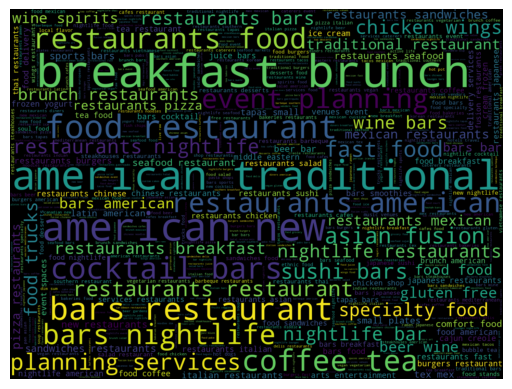

In [ ]:
# Wordcloud of post Covid categories
from wordcloud import WordCloud
text_data = ' '.join(
    item for row in post_df.select("category").collect()
    for item in row['category']
)

# Generate WordCloud using frequency data
wordcloud = WordCloud(width=1440, height=1080, max_words=500).generate(text_data)


# Display the updated word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This word cloud visualizes the most common business categories in the Post Covid dataset, with larger words representing higher frequencies. It shows that food and beverage-related categories dominate, particularly breakfast & brunch, American (traditional and new), bars, and restaurants. There is also a notable presence of specific cuisines like sushi, Asian fusion, and Mexican, along with service-oriented categories such as event planning and coffee & tea.

## Pre - Covid Analysis

### City EDA

<ipython-input-83-d81fcf567e34>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




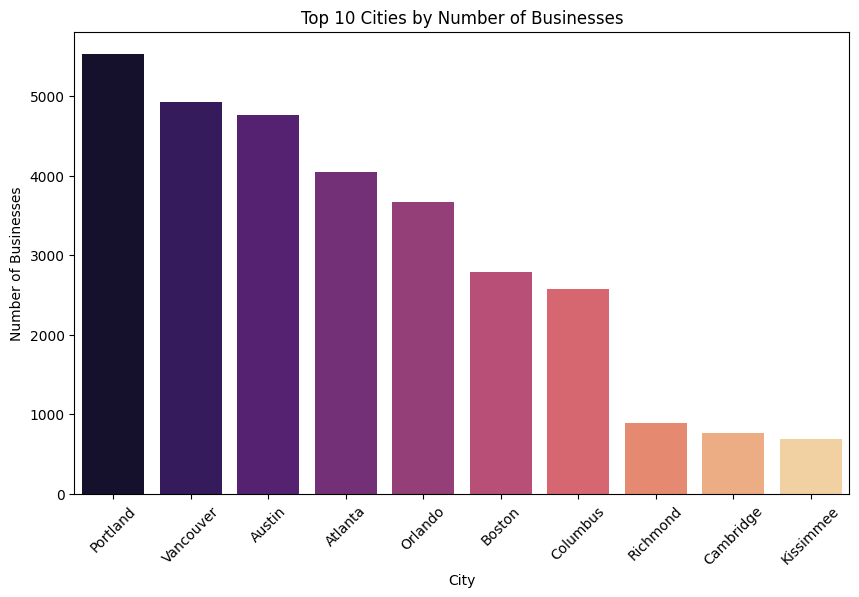

In [ ]:
# Plotting the top 10 cities based on number of business
# Converting post df to pandas
city_counts=pre_df.groupBy("city_standardized").agg(countDistinct("business_id").alias("count")).orderBy(col("count"),ascending = False)
# Sorting and plotting the top 10
top_cities=city_counts.limit(10).toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="city_standardized",y="count",data=top_cities,palette="magma")
plt.xticks(rotation=45)

# Setting the labels and the title
plt.title("Top 10 Cities by Number of Businesses")
plt.xlabel("City")
plt.ylabel("Number of Businesses")

# Displaying the plot
plt.show()

Still the cities with most businesses are Vancouver and Portland, followed by Austin and Atlanta.

### Open or Closed EDA

<ipython-input-84-64fddf06d752>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




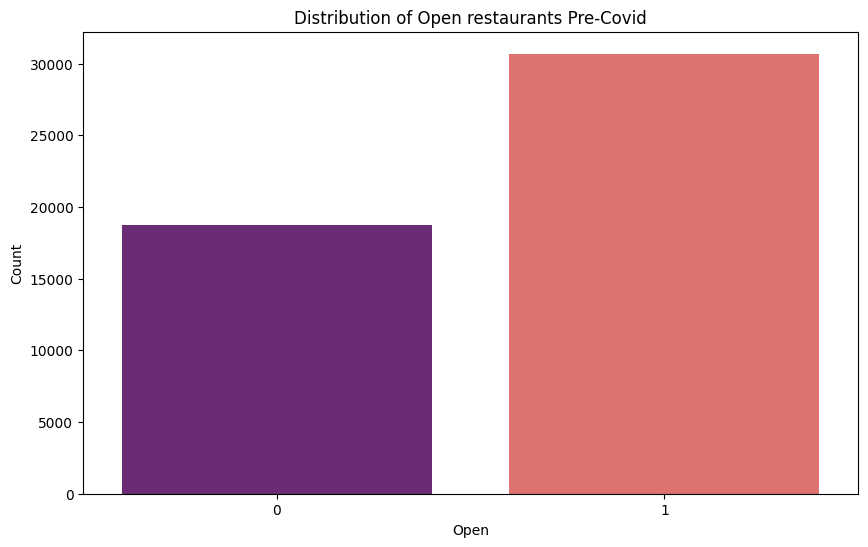

In [ ]:
count_closed_pre = pre_df.groupBy("is_open").agg(countDistinct('business_id').alias("count")).toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="is_open",y="count",data=count_closed_pre,palette="magma")
# Add labels and title
plt.xlabel("Open")
plt.ylabel("Count")
plt.title("Distribution of Open restaurants Pre-Covid")
plt.show()

Before COVID, most restaurants were open, but a significant number were closed, showing a more balanced situation compared to post-COVID, above.

### Customer Stars EDA

<ipython-input-85-36fdb16b95f5>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




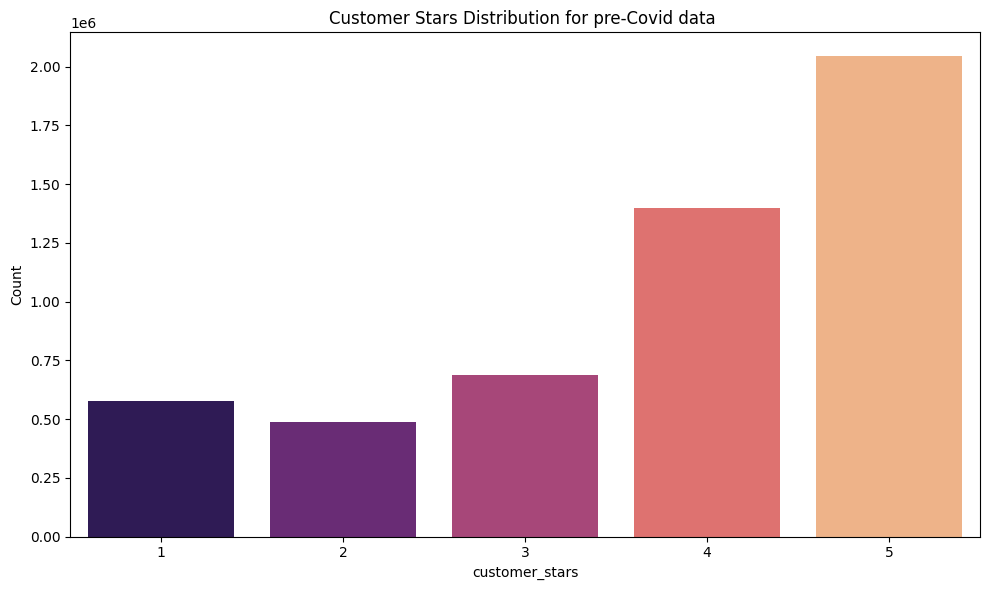

In [ ]:
df_stars_pre = pre_df.select('customer_stars').toPandas()

plt.figure(figsize=(10,6))
# Plot : Distribution of stars from pre_df
sns.countplot(x='customer_stars', data=df_stars_pre, palette='magma',
              order=sorted(df_stars_pre['customer_stars'].dropna().unique()))
plt.title("Customer Stars Distribution for pre-Covid data ")
plt.xlabel('customer_stars')
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Before COVID, customer reviews were mostly positive, with a strong peak at 5 stars and a more even distribution across lower ratings.

### Useful EDA

<ipython-input-86-aeffe44c4dcc>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




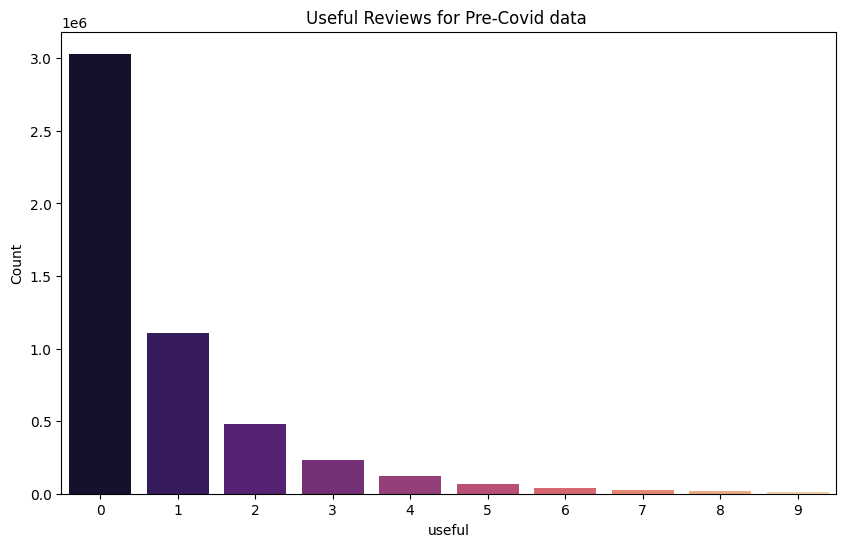

In [ ]:
# Filter for useful values between 0 and 10
df_useful_pre = pre_df.select('useful').filter(col("useful")<10).toPandas()

plt.figure(figsize=(10,6))

# Plot : Distribution of stars from pre_df
sns.countplot(x='useful', data=df_useful_pre, palette='magma',
              order=sorted(df_useful_pre['useful'].dropna().unique()))
plt.title("Useful Reviews for Pre-Covid data ")
plt.xlabel('useful')
plt.ylabel("Count")
plt.show()

### Funny EDA

<ipython-input-87-b1002b1efa4e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




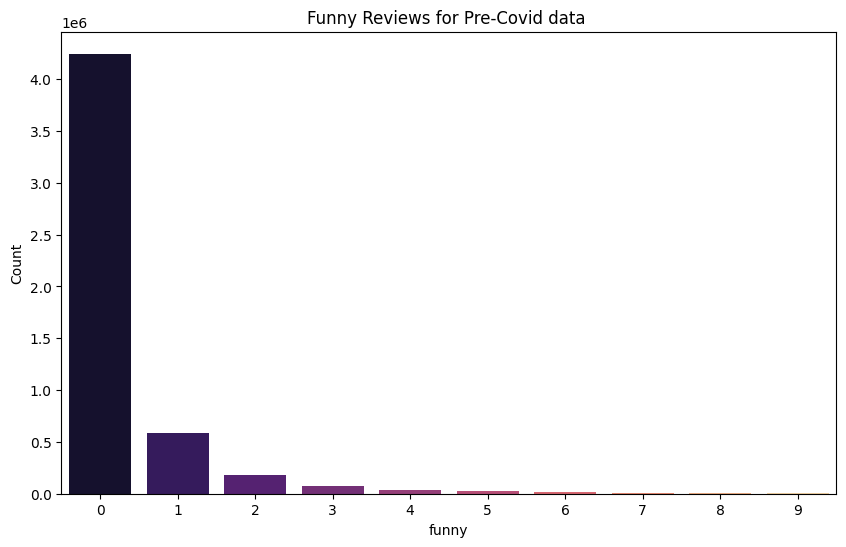

In [ ]:
# Filter for funny values between 0 and 10
df_funny_pre = pre_df.select('funny').filter(col('funny')<10).toPandas()

plt.figure(figsize=(10,6))
# Plot : Distribution of stars from pre_df
sns.countplot(x='funny', data=df_funny_pre, palette='magma',
              order=sorted(df_funny_pre['funny'].dropna().unique()))
plt.title("Funny Reviews for Pre-Covid data ")
plt.xlabel('funny')
plt.ylabel("Count")
plt.show()

### Cool EDA

<ipython-input-88-e5555b792086>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




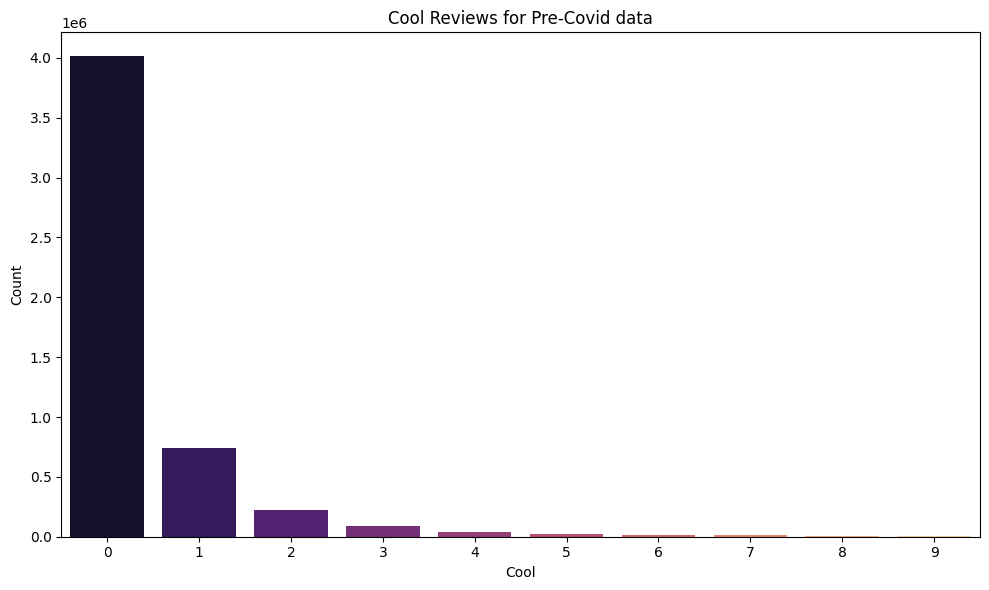

In [ ]:
df_cool_pre = pre_df.select('cool').filter(col('cool')<10).toPandas()

plt.figure(figsize=(10,6))

# Plot the distribution
sns.countplot(x='cool', data=df_cool_pre, palette='magma',
              order=sorted(df_cool_pre['cool'].dropna().unique()))

# Set labels and title
plt.title("Cool Reviews for Pre-Covid data")
plt.xlabel('Cool')
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Stars EDA

<ipython-input-89-7e1cb6086f49>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




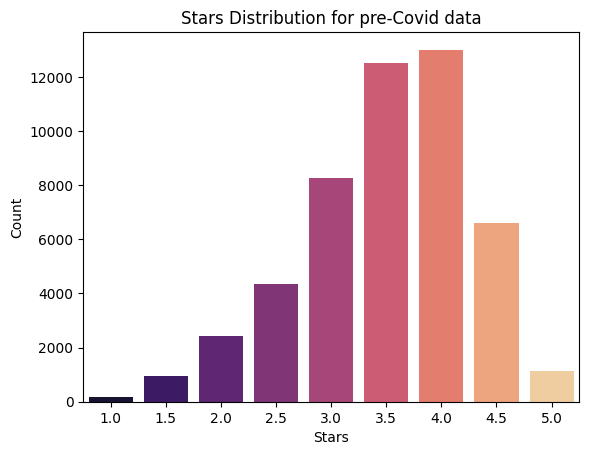

In [ ]:
# Convert the DataFrame to a Pandas DataFrame
df_stars_pre=pre_df.groupBy("stars",'business_id').agg(countDistinct('business_id').alias("count")).toPandas()

# Plot : Some distribution from other_df
sns.countplot(x='stars', data=df_stars_pre, palette='magma',
              order=sorted(df_stars_pre['stars'].dropna().unique()))
plt.title("Stars Distribution for pre-Covid data")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

In the pre-COVID dataset, a similar pattern to the post-COVID one is observed, but with a noticeably higher count of ratings overall.

### Categories

Top 10 categories pre covid with the most reviews

In [ ]:
pre_df = pre_df.withColumn("category", split(col("categories"), ","))
pre_df.select(explode(col("category")).alias("category")).groupBy("category").count().sort("count",ascending = False,truncate=False).show(10)

+--------------------+-------+
|            category|  count|
+--------------------+-------+
|         Restaurants|3911665|
|                Food|1400728|
|           Nightlife|1347742|
|                Bars|1311984|
|         Restaurants|1283334|
|      American (New)| 810203|
| American (Tradit...| 797334|
|  Breakfast & Brunch| 753445|
|          Sandwiches| 555881|
|             Seafood| 428419|
+--------------------+-------+
only showing top 10 rows



Removing whitespace and converting to lower case

In [ ]:
# Trim and lowercase each item
def clean_category_list(cat_list):
    return [c.strip().lower() for c in cat_list if c]

clean_udf = udf(clean_category_list, ArrayType(StringType()))
pre_df = pre_df.withColumn("category", clean_udf(col("category")))

In [ ]:
pre_df.select(explode(col("category")).alias("category")).distinct().count()

725

<ipython-input-160-c2e60b97e65a>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




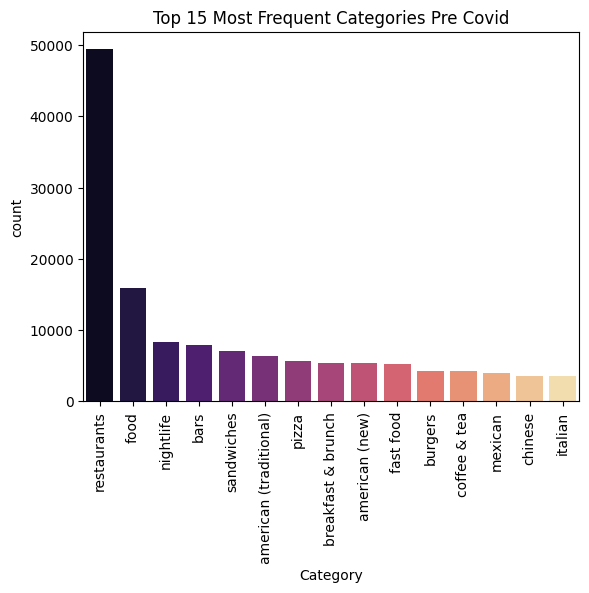

In [ ]:
top_categories_pre = pre_df.select(explode(col("category")).alias("category"),'business_id').groupBy("category").agg(countDistinct("business_id").alias("count")).orderBy("count", ascending=False)
top_categories = top_categories_pre.limit(15)

#  Convert to pandas for plotting
pandas_df = top_categories.toPandas()

sns.barplot(x="category", y="count", data=pandas_df, palette = "magma")
plt.title("Top 15 Most Frequent Categories Pre Covid")
plt.xlabel("Category")
plt.xticks(rotation = 90)
plt.show()

The above bar plot reveals the top 15 categories Pre-COVID, with restaurants, food, nightlife, and bars clearly dominating again in frequency.

<ipython-input-161-ec8fecfe48e5>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




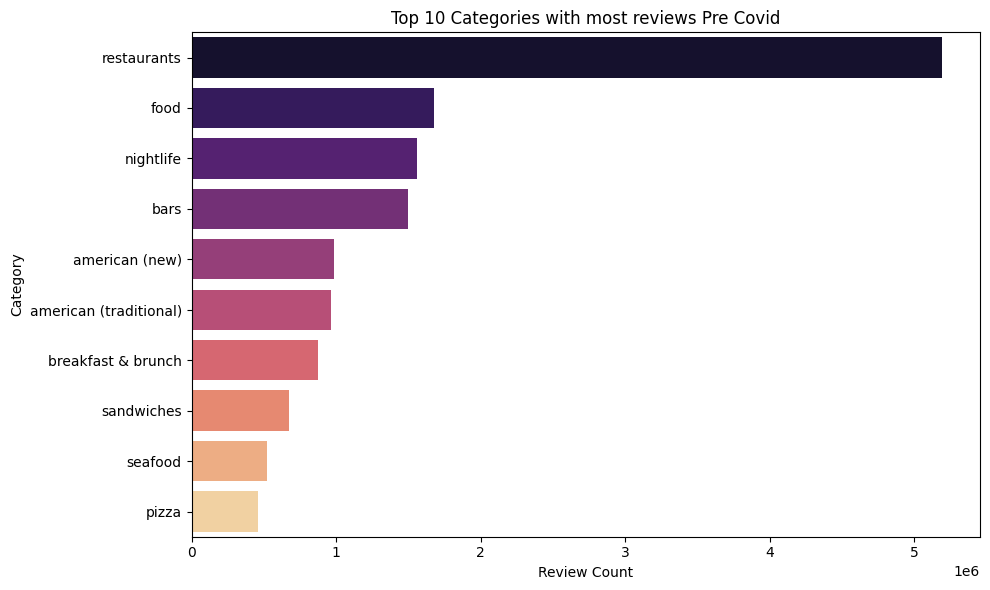

In [ ]:
top_categories_reviews = pre_df.select(explode(col("category")).alias("category")) \
                        .groupBy("category") \
                        .count() \
                        .orderBy("count", ascending=False)

top_categories_pd_pre = top_categories_reviews.limit(10).toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x="count", y="category", data=top_categories_pd_pre, palette="magma")
plt.title("Top 10 Categories with most reviews Pre Covid")
plt.xlabel("Review Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


The top 15 categories are the same in the pre covid dataset as well as the top reviewed ones.

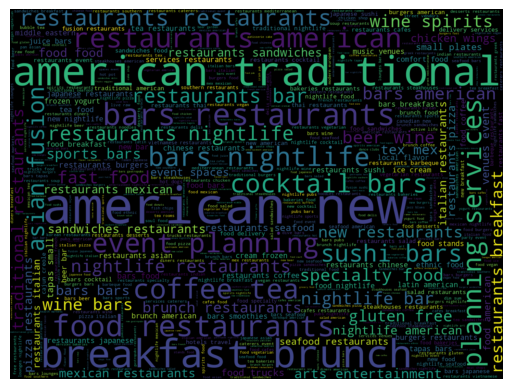

In [ ]:
# Wordcloud of lemmatized categories
sample_pre_df = pre_df.sample(withReplacement=False, fraction=0.1, seed=42)
text_data = ' '.join(
    item for row in sample_pre_df.select("category").collect()
    for item in row['category']
)
#text_data = ' '.join([item for sublist in sampled_pre_df.select("lemmatized").rdd.flatMap(lambda x: x).collect() for item in sublist])
# Generate WordCloud using frequency data
wordcloud = WordCloud(width=1440, height=1080, max_words=500).generate(text_data)


# Display the updated word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This word cloud visualizes business categories from the Pre-COVID period. Categories like American traditional, American new, breakfast & brunch, bars, and restaurants appear most prominently, reflecting their popularity. Other frequently occurring categories include coffee & tea, sushi bars, cocktail bars, and event planning services, indicating a vibrant mix of dining, nightlife, and social event businesses.

Top 20 categories pre and post covid with average highest customer stars




In [ ]:
post_df_cat = post_df.withColumn("category", explode(col("category")))
pre_df_cat = pre_df.withColumn("category", explode(col("category")))
print("Top categories post COVID")
post_df_cat.groupBy("category").agg(count("*").alias("review_count"),avg("customer_stars").alias("avg_rating")) \
    .orderBy("review_count", ascending=False) \
    .show(20, truncate=False)
print("Top categories pre COVID")
pre_df_cat.groupBy("category").agg(count("*").alias("review_count"),avg("customer_stars").alias("avg_rating")) \
    .orderBy("review_count", ascending=False) \
    .show(20, truncate=False)

Top categories post COVID
+-------------------------+------------+------------------+
|category                 |review_count|avg_rating        |
+-------------------------+------------+------------------+
|restaurants              |368193      |3.8746934352364115|
|food                     |119731      |3.985383902247538 |
|nightlife                |96656       |3.915556199304751 |
|bars                     |93741       |3.919138904001451 |
|breakfast & brunch       |58912       |3.9495688484519285|
|american (traditional)   |58603       |3.6993327986621845|
|american (new)           |54281       |3.9279674287503914|
|sandwiches               |47200       |3.8984322033898304|
|seafood                  |37839       |3.8653769919923886|
|mexican                  |36738       |3.772469922151451 |
|pizza                    |36161       |3.7617045988772433|
|burgers                  |30335       |3.4790176363936047|
|cocktail bars            |29197       |4.06647943281844  |
|coffee & tea 

Due to inconsistencies in the 'categories' column, we chose to use this column only for exploratory data analysis (EDA) and not for modeling.

## Comparisons Between Pre and Post Covid

### Review Count Bar Plot

Finding the total review count for each restauraunt pre and post covid

In [ ]:
top_pre1=pre_df.groupby("name").agg(sum("review_count").alias("review_count_pre")).orderBy("review_count_pre", ascending=False).limit(20)

In [ ]:
top_post1=post_df.groupby("name").agg(sum("review_count").alias("review_count_post")).orderBy("review_count_post", ascending=False).limit(20)

In [ ]:
# Converting the dataframes to pandas
top_pre_pd=top_pre1.toPandas()
top_post_pd=top_post1.toPandas()

<ipython-input-93-2fa05c82bf91>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




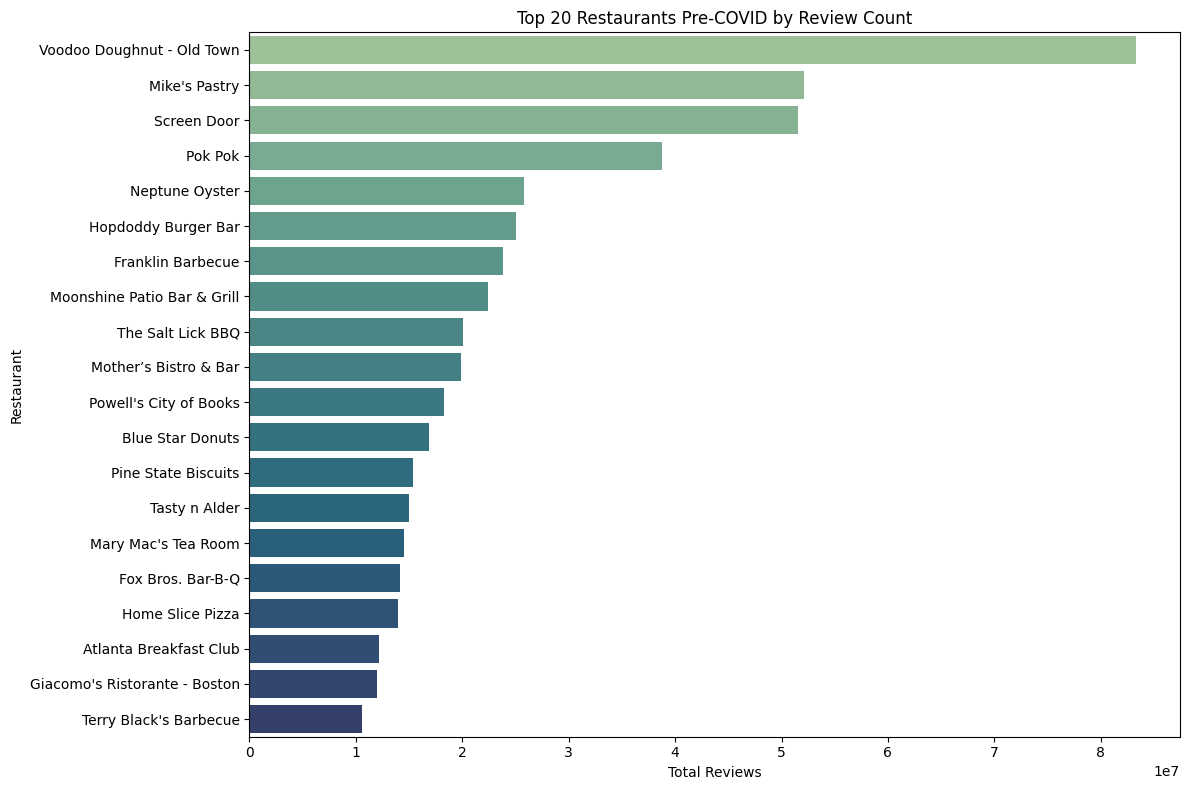

In [ ]:
# Bar plot for pre covid review counts
# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='review_count_pre', y='name', data=top_pre_pd, palette='crest')
plt.title('Top 20 Restaurants Pre-COVID by Review Count')
plt.xlabel('Total Reviews')
plt.ylabel('Restaurant')
plt.tight_layout()
plt.show()

<ipython-input-94-af4c6584fad1>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




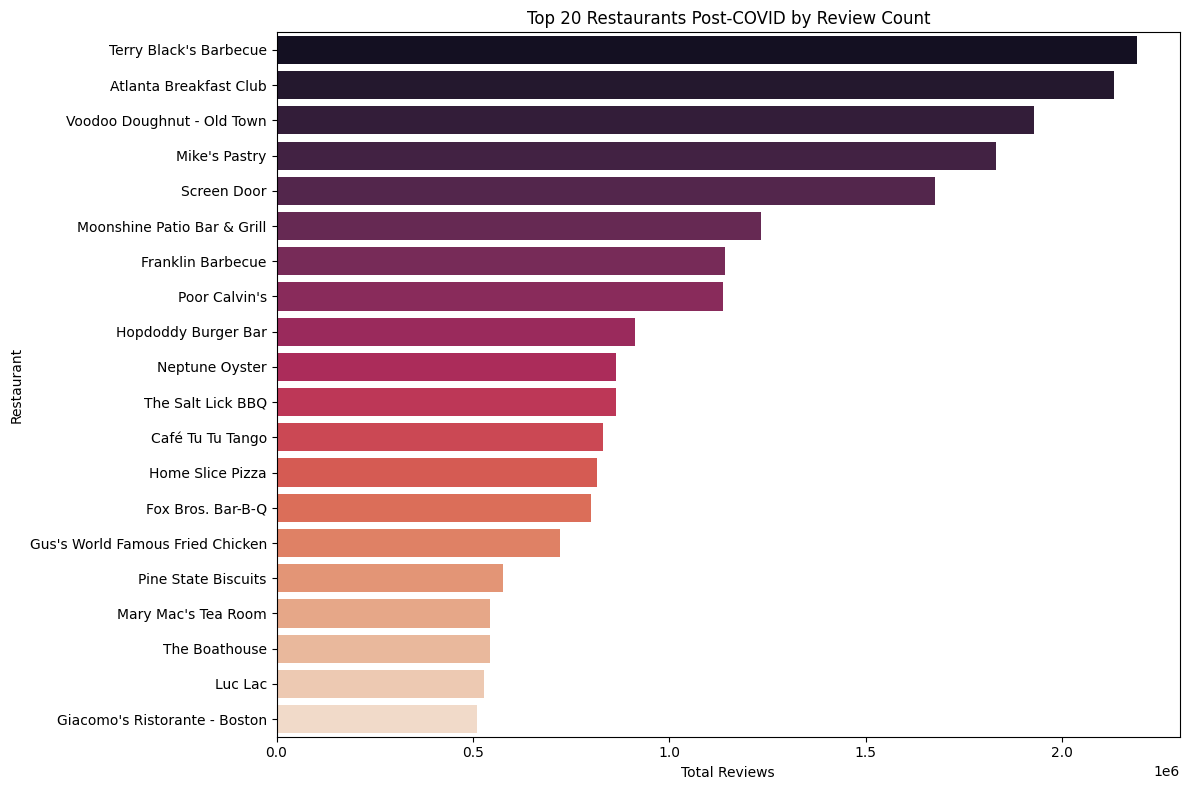

In [ ]:
# Bar plot for post covid review counts
#top_post_pd = top_post_pd.sort_values(by='review_count_post', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='review_count_post', y='name', data=top_post_pd, palette='rocket')
plt.title('Top 20 Restaurants Post-COVID by Review Count')
plt.xlabel('Total Reviews')
plt.ylabel('Restaurant')
plt.tight_layout()
plt.show()


From the above bar plots we can notice that some restaurants appear in both time periods, the pre-COVID dataset shows significantly higher total review counts, indicating more frequent customer engagement and reviewing activity before the pandemic. This might reflect a shift in the customer behavior.
Interestingly, the Voodoo Doughnut remained a top contender across both periods, showing consistent popularity despite the pandemic.
Another interesting finding,is that Terry Black’s Barbecue showed a significant rise in popularity post-COVID, becoming the most reviewed restaurant in the post-pandemic period, despite being among the least reviewed in the pre-COVID top 20.

### Customers stars

In [ ]:
# Average Customers Stars in pre dataset
c_stars_pre=pre_df.groupby("name").agg(avg("customer_stars").alias("avg_cust_stars_pre"))

In [ ]:
#  Average Customers Stars in post dataset
c_stars_post=post_df.groupby("name").agg(avg("customer_stars").alias("avg_cust_stars_post"))

In [ ]:
# Joining the two new datasets
c_stars_compare = c_stars_pre.join(c_stars_post, on='name', how='inner')

In [ ]:
# Adding the difference to the dataset
c_stars_compare = c_stars_compare.withColumn(
    "star_change",
    col("avg_cust_stars_post") - col("avg_cust_stars_pre")
)

# Displaying the dataframe
c_stars_compare.show()

+--------------------+------------------+-------------------+--------------------+
|                name|avg_cust_stars_pre|avg_cust_stars_post|         star_change|
+--------------------+------------------+-------------------+--------------------+
|      Yue Restaurant|               4.0|                4.0|                 0.0|
|       Poor Calvin's| 4.398334934357989|  4.559523809523809| 0.16118887516581992|
|            Larosa's| 4.208333333333333|              4.375| 0.16666666666666696|
|Grindhouse Killer...|3.7771300448430494|  3.815668202764977|0.038538157921927496|
|          Copeland's|3.7967359050445104|  4.081081081081081|  0.2843451760365703|
| Emerald City Bagels| 4.088050314465409| 3.0232558139534884| -1.0647945005119208|
|Applebee's Grill ...|2.2987264673311185| 2.2412451361867705|-0.05748133114434806|
|         Il Localino| 3.806366047745358|  4.511111111111111|   0.704745063365753|
|Wadada Healthy Ma...|               4.0|                4.5|                 0.5|
|Kik

Selecting the top 5 based on the increase and decrease of the customers stars.

In [ ]:
# Top 5: increase in stars
# Increase in satisfaction
c_stars_compare.orderBy("star_change", ascending=False).show(5,truncate=False)

+--------------------------+------------------+-------------------+------------------+
|name                      |avg_cust_stars_pre|avg_cust_stars_post|star_change       |
+--------------------------+------------------+-------------------+------------------+
|Cholo Dogs                |1.0               |5.0                |4.0               |
|Antonio's Pizza & Subs    |1.1428571428571428|5.0                |3.857142857142857 |
|Bud Light Port Paradise   |1.4444444444444444|5.0                |3.5555555555555554|
|Kawawa Japanese Restaurant|1.5               |5.0                |3.5               |
|JB's Sports Bar and Grille|1.5               |5.0                |3.5               |
+--------------------------+------------------+-------------------+------------------+
only showing top 5 rows



We can notice from above a massive improvement in customer satisfaction in those 5 restauraunts.

Selecting only the reviews for the restaurants with the highest improvement in customer stars

In [ ]:
# Selectin the top 5 improved ones
top_5_improved = post_df.filter(post_df.name.isin("Cholo Dogs","Antonio's Pizza & Subs","Bud Light Port Paradise","JB's Sports Bar and Grille","Kawawa Japanese Restaurant"))

In [ ]:
# Displaying the top 5
top_5_improved.show()

+--------------------+--------------------+--------------------+------+-----------+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+-----------------+
|         business_id|                name|             address|state_|postal_code|  latitude|   longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|city_standardized|
+--------------------+--------------------+--------------------+------+-----------+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+-----------------+
|G6h-WlELLFXycZ2ZT...|          Cholo Dogs|  150 S Magnolia Ave|   

In [ ]:
# Cholo's post reviews and customers stars
post_df.filter(col("name") == "Cholo Dogs").select("customer_stars", "text_").show(10,truncate=False)

+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_stars|text_                                                                                                                                                                                                                                                                                                                                                                                                                    

Cholo Dogs is one of the few restaurants that gained popularity after COVID-19, possibly due to its expansion from a food truck to a permanent location during the pandemic. Also, on 2023 they won Orlando's Best Food Truck award.

https://www.instagram.com/cholodogs/p/CwTS-T2vCii/?utm_source=chatgpt.com&img_index=1
https://www.orlandoweekly.com/food-drink/mexican-hot-dog-vendor-cholo-dogs-to-move-into-downtown-orlandos-market-on-magnolia-27259130

In [ ]:
# How many reviews Cholo has
post_df.filter(col("name") == "Cholo Dogs").agg(count("text_").alias("total_reviews")).show()

+-------------+
|total_reviews|
+-------------+
|            6|
+-------------+



In [ ]:
# if we have more than one cholo
post_df.filter(col("name") == "Cholo Dogs").count()

6

In [ ]:
pre_df.filter(col("name") == "Cholo Dogs").select("customer_stars", "text_").show(truncate=False)

+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_stars|text_                                                                                                                                                                                                         |
+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1             |$6 for a .25c hot dog slathered in spicy mayo sauce. The hot dog guy was funny tho. I feel this is just a money grab with no intention of giving the buyer a quality dog/brat/sausage. Too many other options.|
+--------------+----------------------------------------------------------------------------------------

In [ ]:
pre_df.filter(col("name") == "Cholo Dogs").agg(count("text_").alias("total_reviews")).show()

+-------------+
|total_reviews|
+-------------+
|            1|
+-------------+



In [ ]:
pre_df.filter(col("name") == "Cholo Dogs").agg(sum("review_count").alias("total_reviews")).show()

+-------------+
|total_reviews|
+-------------+
|            7|
+-------------+



In [ ]:
post_df.filter(col("name") == "Cholo Dogs").agg(sum("review_count").alias("total_reviews")).show()

+-------------+
|total_reviews|
+-------------+
|           42|
+-------------+



In [ ]:
# Top 5: decrease in stars
# Decrease in satisfaction
c_stars_compare.orderBy("star_change", ascending=True).show(5,truncate =False)

+------------------------------+------------------+-------------------+-----------+
|name                          |avg_cust_stars_pre|avg_cust_stars_post|star_change|
+------------------------------+------------------+-------------------+-----------+
|Hindsight Beer Cart           |5.0               |1.0                |-4.0       |
|Amanecer Coffee Shop & Bakery |5.0               |1.0                |-4.0       |
|High Roller Sushi             |5.0               |1.0                |-4.0       |
|Los Jefes                     |5.0               |1.0                |-4.0       |
|Alecomfe Coffee and Restaurant|5.0               |1.0                |-4.0       |
+------------------------------+------------------+-------------------+-----------+
only showing top 5 rows



In [ ]:
# Selecting the top 5 that their preformance declined
top_5_decrease = post_df.filter(post_df.name.isin("Hindsight Beer Cart","Super Carniceria Jalisco","Alecomfe Coffee and Restaurant","Amanecer Coffee Shop & Bakery","Pho Le 2"))
top_5_decrease.count()

10

In [ ]:
# Displaying them
top_5_decrease.show()

+--------------------+--------------------+--------------------+------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+-----------------+
|         business_id|                name|             address|state_|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|city_standardized|
+--------------------+--------------------+--------------------+------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+-----------------+
|883-VFEmN-7zhqmUM...|Super Carniceria ...|6200 S

In [ ]:
# Selecting the Hindsight Beer Cart and displaying the post customers stars and  text
post_df.filter(col("name") == "Hindsight Beer Cart").select("customer_stars", "text_").show(truncate=False)

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_stars|text_                                                                                                                                                                   |
+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1             |Good beer but every time I've come to this pod during COVID the employees are unmasked. They've lost my business because of that. We all play a part, please play yours.|
+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [ ]:
# Selecting the Hindsight Beer Cart and displaying the pre customers stars and  text
pre_df.filter(col("name") == "Hindsight Beer Cart").select("customer_stars", "text_").show(truncate=False)

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

As shown above, Hindsight Beer Cart was receiving high ratings before COVID, but its performance declined afterward. Based on the review texts in our dataset, this may be linked to customer concerns about staff not wearing masks.

In [ ]:
# Total review count (pre dataset) for "Hindsight Beer Cart"
pre_df.filter(col("name") == "Hindsight Beer Cart").agg(sum("review_count").alias("total_reviews")).show()

+-------------+
|total_reviews|
+-------------+
|           42|
+-------------+



In [ ]:
# Total review count (post dataset) for "Hindsight Beer Cart"
post_df.filter(col("name") == "Hindsight Beer Cart").agg(sum("review_count").alias("total_reviews")).show()

+-------------+
|total_reviews|
+-------------+
|            7|
+-------------+



### Customer Satisfaction based on Customers Stars

In [ ]:
# Join on restaurant name
c_stars_compare_1 = c_stars_pre.join(c_stars_post, on='name', how='inner').orderBy(col('avg_cust_stars_pre'), ascending=False)

In [ ]:
#c_stars_compare_pd = c_stars_compare_1.toPandas()

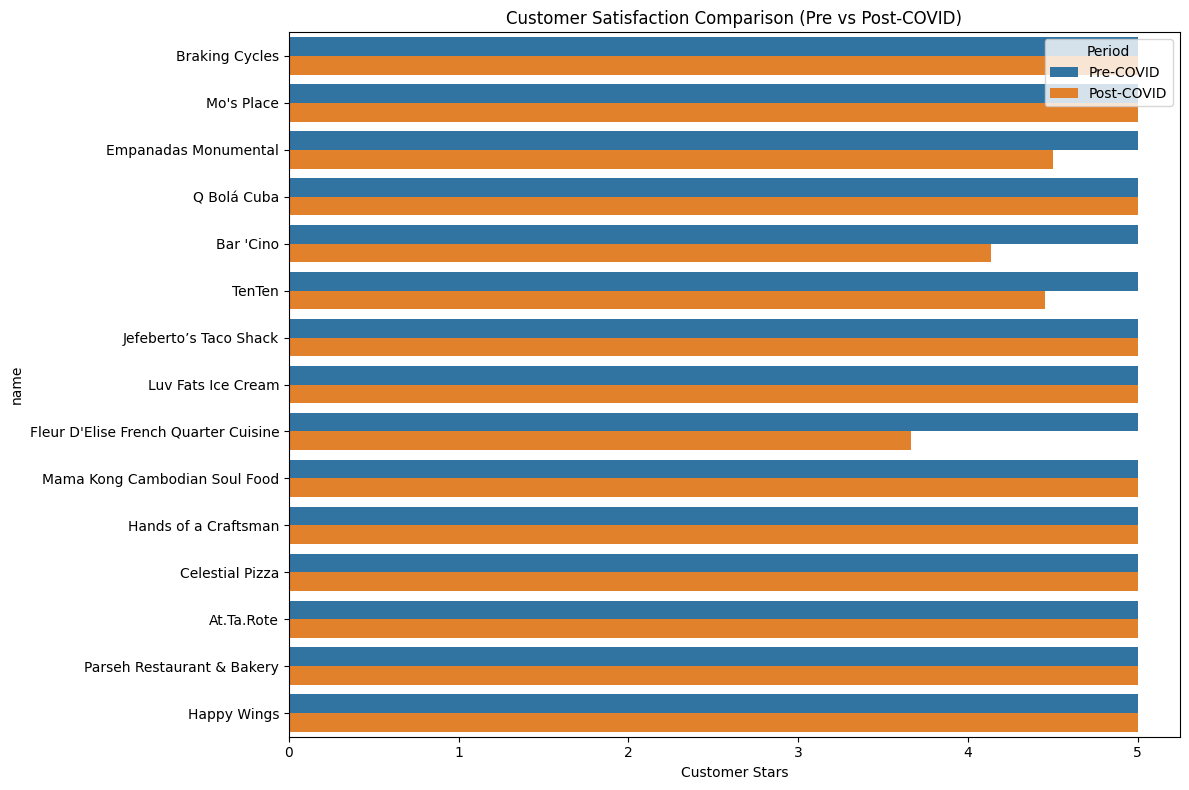

In [ ]:
# Take top 15 restaurants by pre-COVID customer stars
#top = c_stars_compare_pd.sort_values(by='avg_cust_stars_pre', ascending=False).head(15)
top = c_stars_compare_1.limit(15).toPandas()
# Melt for Seaborn plotting
melted = top.melt(id_vars='name',
                  value_vars=['avg_cust_stars_pre', 'avg_cust_stars_post'],
                  var_name='Period',
                  value_name='Customer Stars')

# Clean period labels
melted['Period'] = melted['Period'].replace({
    'avg_cust_stars_pre': 'Pre-COVID',
    'avg_cust_stars_post': 'Post-COVID'
})

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted, x='Customer Stars', y='name', hue='Period')
plt.title('Customer Satisfaction Comparison (Pre vs Post-COVID)')
plt.tight_layout()
plt.show()


The above plot shows the customer satisfaction ratings (on a 1–5 star) before and after COVID-19 for the 15 selected restaurants.
Braking Cycles, Empanadas Monumental, and Mama Kong Cambodian Soul Food, maintained consistently high ratings. However, Bar 'Cino and Fleur D'Elise French Quarter Cuisine experienced noticeable declines in post-COVID ratings, suggesting a potential drop in customer satisfaction or operational challenges during/after the pandemic.

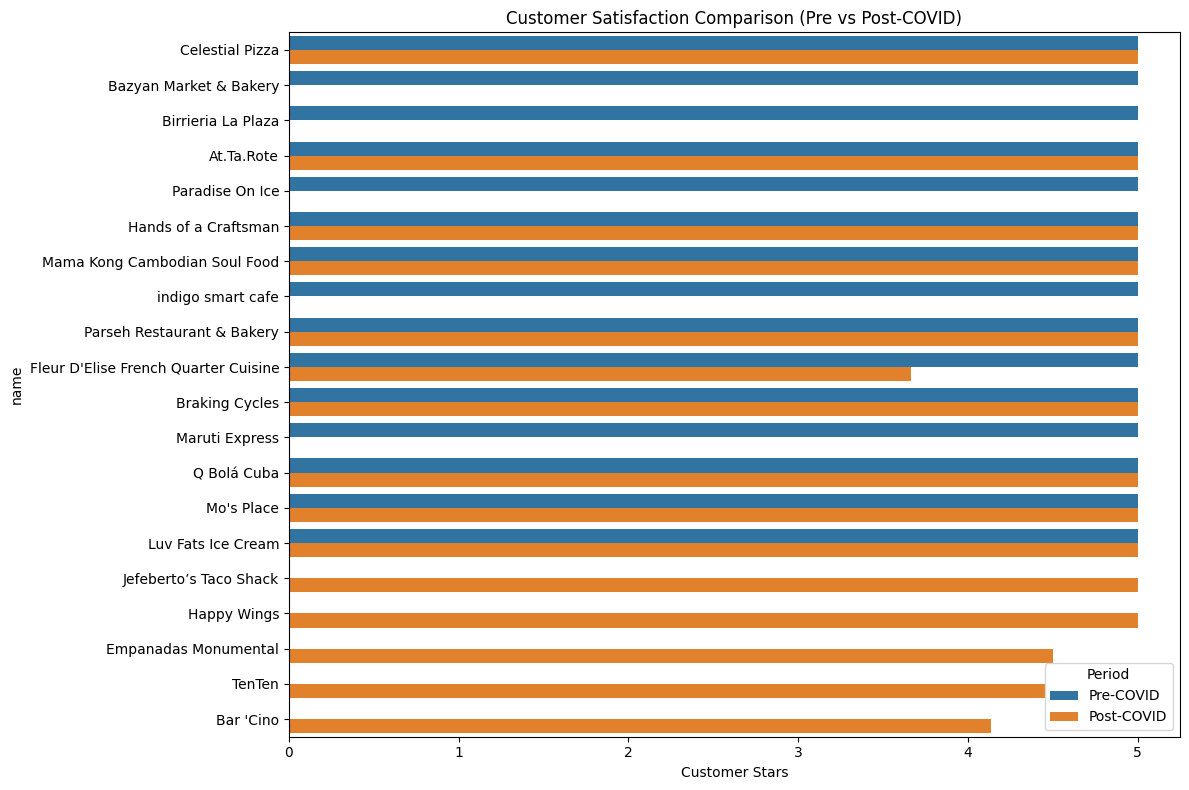

In [ ]:
# Take top 15 restaurants by pre-COVID customer stars
#top = c_stars_compare_pd.sort_values(by='avg_cust_stars_pre', ascending=False).head(15)
top = c_stars_compare_1.limit(15)

# Melting the dataframe
melted = top.select(
    "name",
    lit("Pre-COVID").alias("Period"),
    col("avg_cust_stars_pre").alias("Customer Stars")
).union(
    top.select(
        "name",
        lit("Post-COVID").alias("Period"),
        col("avg_cust_stars_post").alias("Customer Stars")
    )
)

melted_sorted = melted.orderBy(col("Customer Stars"), ascending = False)
melted_sorted = melted_sorted.toPandas()

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_sorted, x='Customer Stars', y='name', hue='Period')
plt.title('Customer Satisfaction Comparison (Pre vs Post-COVID)')
plt.tight_layout()
plt.show()


In [ ]:
# Distinct names of restauraunts in post dataset
post_df.select(col("name")).distinct().count()

21595

In [ ]:
# Distinct names of restauraunts in pre dataset
pre_df.select(col("name")).distinct().count()

36260

In [ ]:
# Displaying the unique businesses ordering by the business id (post)
post_df.select("business_id", "name").distinct().orderBy("business_id").count()

30061

In [ ]:
# Displaying the unique businesses ordering by the business id (pre)
pre_df.select("business_id", "name").distinct().orderBy("business_id").count()

49404

In [ ]:
# Displaying the dataset that was created to compare the average stars of pre and post
c_stars_compare.show()

+--------------------+------------------+-------------------+--------------------+
|                name|avg_cust_stars_pre|avg_cust_stars_post|         star_change|
+--------------------+------------------+-------------------+--------------------+
|      Yue Restaurant|               4.0|                4.0|                 0.0|
|       Poor Calvin's| 4.398334934357989|  4.559523809523809| 0.16118887516581992|
|            Larosa's| 4.208333333333333|              4.375| 0.16666666666666696|
|Grindhouse Killer...|3.7771300448430494|  3.815668202764977|0.038538157921927496|
|          Copeland's|3.7967359050445104|  4.081081081081081|  0.2843451760365703|
| Emerald City Bagels| 4.088050314465409| 3.0232558139534884| -1.0647945005119208|
|Applebee's Grill ...|2.2987264673311185| 2.2412451361867705|-0.05748133114434806|
|         Il Localino| 3.806366047745358|  4.511111111111111|   0.704745063365753|
|Wadada Healthy Ma...|               4.0|                4.5|                 0.5|
|Kik

Restaurant with a decline in their stars Post Covid

In [ ]:
# Declined Stars rating
restaurants_declined = c_stars_compare.filter(c_stars_compare.star_change <= -2)
restaurants_declined.show()

+--------------------+------------------+-------------------+-------------------+
|                name|avg_cust_stars_pre|avg_cust_stars_post|        star_change|
+--------------------+------------------+-------------------+-------------------+
|          Pizza King|3.3417721518987342|                1.0|-2.3417721518987342|
|  Amano's Sports Bar|3.3333333333333335|                1.0|-2.3333333333333335|
|          Sushi Boss|4.0344827586206895|                1.0|-3.0344827586206895|
|Fatty Cow Seafood...| 3.086021505376344|                1.0| -2.086021505376344|
|       Teriyaki Town| 4.111111111111111|                1.0|-3.1111111111111107|
|        King Express|3.8421052631578947|                1.0|-2.8421052631578947|
|Taste Bay Restaurant|3.8260869565217392| 1.6666666666666667|-2.1594202898550723|
|Tv Dinners Cafete...|               4.6|                1.0|-3.5999999999999996|
|   La Bodega Gourmet| 4.507462686567164| 2.3333333333333335| -2.174129353233831|
|Chi-Town Hot Do

In [ ]:
# Get list of names from restaurants_declined
declined_names = [row["name"] for row in restaurants_declined.select("name").distinct().collect()]

# Filter post_df by those names
restaurants_declined_post = post_df.filter(col("name").isin(declined_names))

In [ ]:
restaurants_declined_post  = restaurants_declined_post.withColumn("Reviews",
    regexp_replace(lower(restaurants_declined_post["text_"]), "[^a-zA-Z0-9\s]", ""))

# Remove \n\n and replace with a space
restaurants_declined_post = restaurants_declined_post.withColumn(
    "cleaned_reviews", regexp_replace("Reviews", "\n+", " ")  # Replaces multiple newlines with a space
)

# Tokenize text into words
restaurants_declined_post = restaurants_declined_post.withColumn("words", split("cleaned_reviews", " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_post")
restaurants_declined_post = remover.transform(restaurants_declined_post)

In [ ]:
# Tokenize and remove stopwords (same as before)
cv = CountVectorizer(inputCol="filtered_words_post", outputCol="raw_features", vocabSize=10000, minDF=5.0)
cvmodel = cv.fit(restaurants_declined_post)
result_cv = cvmodel.transform(restaurants_declined_post)
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

# Apply LDA for topic modeling
lda = LDA(k=15,featuresCol="raw_features",seed=42)
lda_model = lda.fit(result_tfidf)
lda_result = lda_model.transform(result_tfidf)

# Now to print our topics:
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 8)
vocabList = cvmodel.vocabulary

# we print the final topics
for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
wedding
cost
guests
fee
process
pay
grocery
drinks
------------------
Topic ID:1
cheap
us
tiny
flavor
burger
fries
wings
flavorless
------------------
Topic ID:2
steak
tacos
wall
al
better
expect
hole
decent
------------------
Topic ID:3
didnt
cook
store
check
back
asked
well
money
------------------
Topic ID:4

food
place
like
order
go
back
get
------------------
Topic ID:5

like
customers
front
sanitizer
hand
cashier
put
------------------
Topic ID:6
y
que
la
para
de
el
comida
en
------------------
Topic ID:7
outside
last
talking
orders
three
wrong
follow
third
------------------
Topic ID:8
ordered
hair
dish
sent
restaurant
food
think
never
------------------
Topic ID:9
put
said
asked
times
rude
annoyed
change
lower
------------------
Topic ID:10
one
food
back
beware
use

bag
ones
------------------
Topic ID:11

sandwich
annoying
cafe
super
inform
soon
staff
------------------
Topic ID:12

gloves
food
outdoor
business
appetizer
neighborhood
years
------------------
Topic I

From the declined restaurants, we applied LDA, which produced multiple topics.
Each topic is a distribution over words, capturing common themes in the text.

One topic, for example, appears to relate to hygiene and staff behavior. This topic includes words such as:

“customers,” “front,” “sanitizer,” “hand,” “cashier”

These words suggest concerns about cleanliness, particularly around hand hygiene, sanitizer availability, and cashier interactions — all of which were especially important during the Covid-19 period.

This topic likely highlights one of the key reasons for customer dissatisfaction, and possibly contributes to the decline in restaurant performance post-Covid.

Restaurants with an improvement in their stars Post Covid

In [ ]:
# Restauraunts that was improved based on stars rating
restaurants_improved = c_stars_compare.filter(c_stars_compare.star_change > 2)
restaurants_improved.show()

+--------------------+------------------+-------------------+------------------+
|                name|avg_cust_stars_pre|avg_cust_stars_post|       star_change|
+--------------------+------------------+-------------------+------------------+
|        Bachata Rosa|              2.25|                5.0|              2.75|
|He Hop Chinese Re...|2.5714285714285716|                5.0|2.4285714285714284|
|Jackson Square Ta...|2.8275862068965516|                5.0|2.1724137931034484|
|      Oak Creek Cafe|2.8842105263157896|  4.888888888888889|2.0046783625730997|
|    Sojourner's Cafe|2.8360655737704916|                5.0|2.1639344262295084|
|Great Chef Chines...| 2.761904761904762|                5.0| 2.238095238095238|
|JB's Sports Bar a...|               1.5|                5.0|               3.5|
|           V’s Diner|               2.5|                5.0|               2.5|
|            QQ Sushi|2.8596491228070176|                5.0|2.1403508771929824|
|              Ho-Toy| 2.870

In [ ]:
# Get list of names from restaurants_improved
improved_names = [row["name"] for row in restaurants_improved.select("name").distinct().collect()]

# Filter post_df by those names
restaurants_improved_post = post_df.filter(col("name").isin(improved_names))

Preprocessing the review column

In [ ]:
restaurants_improved_post  = restaurants_improved_post.withColumn("Reviews",
    regexp_replace(lower(restaurants_improved_post["text_"]), "[^a-zA-Z0-9\s]", ""))

# Remove \n\n and replace with a space
restaurants_improved_post = restaurants_improved_post.withColumn(
    "cleaned_reviews", regexp_replace("Reviews", "\n+", " ")  # Replaces multiple newlines with a space
)

# Tokenize text into words
restaurants_improved_post = restaurants_improved_post.withColumn("words", split("cleaned_reviews", " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_post")
restaurants_improved_post = remover.transform(restaurants_improved_post)

LDA on the improved restaurants

In [ ]:
# Tokenize and remove stopwords (same as before)
cv = CountVectorizer(inputCol="filtered_words_post", outputCol="raw_features", vocabSize=10000, minDF=5.0)
cvmodel = cv.fit(restaurants_improved_post)
result_cv = cvmodel.transform(restaurants_improved_post)
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

# Apply LDA for topic modeling
lda = LDA(k=15,featuresCol="raw_features",seed=42)
lda_model = lda.fit(result_tfidf)
lda_result = lda_model.transform(result_tfidf)

# Now to print our topics:
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 8)
vocabList = cvmodel.vocabulary

# we print the final topics
for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
tell
times
area
spot
customer
made
wide
polite
------------------
Topic ID:1
half
theres
local
well
take
located
portions
kitchen
------------------
Topic ID:2
burrito
also
ordered
everything
last
chicken
good
man
------------------
Topic ID:3
many
looking
awesome
expectations
beef
flavor
quickly
given
------------------
Topic ID:4
meat
fries
like
crazy
staff
friendly
chicken
really
------------------
Topic ID:5
guy
got
today
served
us
give
garlic
3
------------------
Topic ID:6

yummy
coffee
delicious
spot
looking
get
order
------------------
Topic ID:7
better
tonight
today
thai
please
value
manager
family
------------------
Topic ID:8
neighborhood
cafe
cant
say
indian
ordering
onions
japanese
------------------
Topic ID:9

good
rice
soup
nice
ordered
amazing
salad
------------------
Topic ID:10
always
great
life
guys
glad
combination
night
love
------------------
Topic ID:11
style
chicken
yummy
asked
impressed
left
lunch
wow
------------------
Topic ID:12

chicken
fried
ri

We also applied an LDA topic modeling to the reviews of restaurants that improved after Covid and found that the resulting topics reflect mostly positive experiences. Common themes include good food quality, friendly staff, and enjoyable environments.
For example, topics featured words like “delicious,” “great,” “friendly,” “yummy,” and “coffee,” indicating customer satisfaction with meals and service. Compared to the declined restaurants, which showed concerns about hygiene, rudeness, and order issues, the improved restaurants were praised for consistent quality and pleasant experiences, which likely contributed to their post-Covid success.

## Reviews

#### Preprocessing Review Column

In [ ]:
cleaned_precov_df = pre_df.withColumn("Reviews",
    regexp_replace(lower(pre_df["text_"]), "[^a-zA-Z0-9\s]", ""))

cleaned_precov_df.select("Reviews").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
cleaned_postcov_df = post_df.withColumn("Reviews",
    regexp_replace(lower(post_df["text_"]), "[^a-zA-Z0-9\s]", ""))

cleaned_postcov_df.select("Reviews").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
filtered_precov_df_sample = cleaned_precov_df.sample(fraction=0.001)

In [ ]:
filtered_precov_df_sample  = filtered_precov_df_sample .withColumn(
    "cleaned_reviews",
    when(col("Reviews").isNotNull(), regexp_replace("Reviews", "[\n,]+", ""))
    .otherwise("")  # Replace NULLs with an empty string
)

# Tokenize text into words
tokenized_precov_df = filtered_precov_df_sample .withColumn("words", split(col("cleaned_reviews"), " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_pre")
filtered_precov_df = remover.transform(tokenized_precov_df)

# Filter out empty lists after stopword removal
filtered_precov_df = filtered_precov_df.filter(
    (col("filtered_words_pre").isNotNull()) & (size(col("filtered_words_pre")) > 0)
)

# Show cleaned and filtered results
filtered_precov_df.select("filtered_words_pre").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_w

In [ ]:
# Remove \n\n and replace with a space
cleaned_postcov_df = cleaned_postcov_df.withColumn(
    "cleaned_reviews", regexp_replace("Reviews", "\n+", " ")  # Replaces multiple newlines with a space
)

# Tokenize text into words
tokenized_postcov_df = cleaned_postcov_df.withColumn("words", split("cleaned_reviews", " "))

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words_post")
filtered_postcov_df = remover.transform(tokenized_postcov_df)

# Show result
filtered_postcov_df.select("filtered_words_post").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Pre Covid Reviews (Touta en ta etreksa gt enxrw an ta theloume)

Positive

In [ ]:
# Good reviews
pre_df_positive = filtered_precov_df.filter(col("customer_stars")>=4).sample(fraction=0.1,seed=42)

# Top words post Covid for satisfied customers
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_pre = ' '.join([item for sublist in pre_df_positive.select("filtered_words_pre").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_pre = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_pre)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_pre, interpolation="bilinear")
plt.axis('off')
plt.show()

Neutral

In [ ]:
# Neutral reviews
pre_df_neutral = filtered_precov_df.filter(col("customer_stars") == 3).sample(fraction=0.1,seed=42)

# Top words post Covid for satisfied customers
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_pre_neutral = ' '.join([item for sublist in pre_df_neutral.select("filtered_words_pre").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_pre_neutral = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_pre_neutral)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_pre_neutral, interpolation="bilinear")
plt.axis('off')
plt.show()

Negative

In [ ]:
# Negative reviews
pre_df_negative = filtered_precov_df.filter(col("customer_stars") < 3).sample(fraction=0.1,seed=42)

# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_pre_neg = ' '.join([item for sublist in pre_df_negative.select("filtered_words_pre").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_pre_neg = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_pre_neg)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_pre_neg, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Post Covid Reviews (to idio me pano)

Positive

In [ ]:
# Good reviews
post_df_positive = filtered_postcov_df.filter(col("customer_stars")>=4)

# Top words post Covid for satisfied customers
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_post = ' '.join([item for sublist in post_df_positive.select("filtered_words_post").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_post = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_post)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_post, interpolation="bilinear")
plt.axis('off')
plt.show()

Neutral

In [ ]:
# Neutral reviews
post_df_neutral = filtered_postcov_df.filter(col("customer_stars")==3)

# Top words post Covid for satisfied customers
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_post_neutral = ' '.join([item for sublist in post_df_neutral.select("filtered_words_post").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_post_neutral = WordCloud(width=1440, height=1080, max_words=200).generate(text_data_post_neutral)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_post_neutral, interpolation="bilinear")
plt.axis('off')
plt.show()

Negative

In [ ]:
# Good reviews
post_df_negative = filtered_postcov_df.filter(col("customer_stars") <=2)

# Top words post Covid for satisfied customers
# Convert Spark DataFrame to Pandas (collecting only the text column)
text_data_post_neg = ' '.join([item for sublist in post_df_negative.select("filtered_words_post").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_post = WordCloud(width=1440, height=1080, max_words=400).generate(text_data_post_neg)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_post, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Topic Detection for Post Covid Reviews

In [ ]:
# create a CountVectorizer, fit & transform
cv_post = CountVectorizer(inputCol="filtered_words_post", outputCol="raw_features", vocabSize=10000)
cv_model_post = cv_post.fit(filtered_postcov_df)
result_cv_post = cv_model_post.transform(filtered_postcov_df)
# create IDF, fit & transform
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv_post)
result_tfidf = idfModel.transform(result_cv_post)

# Let's train our LDA model
lda = LDA(k=20, maxIter=100,featuresCol="features", seed = 42)
lda_model_post = lda.fit(result_tfidf)
lda_result_df_post = lda_model_post.transform(result_tfidf)

In [ ]:
topicIndices = lda_model_post.describeTopics(maxTermsPerTopic = 8)
vocabList = cv_model_post.vocabulary

# we print the final topics
for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
bbq
brisket
ribs
indian

mac
sides
pork
------------------
Topic ID:1

chicken
portion
size
price
pretty
small
good
------------------
Topic ID:2
great
always
place
love
friendly
staff

food
------------------
Topic ID:3
burger
fries
sandwich
burgers
cheese
donuts

bacon
------------------
Topic ID:4
ramen
cream
ice
chocolate
cake
coffee
toast

------------------
Topic ID:5
us
asked

manager
said
mask
rude
people
------------------
Topic ID:6

business
support
quality
years
community
local
airport
------------------
Topic ID:7
brunch
seating
breakfast
outdoor

patio
great
outside
------------------
Topic ID:8

bar
music
beer
loud
beers
steak
night
------------------
Topic ID:9
pho
la
mi
de
vietnamese
banh
cuban
sushi
------------------
Topic ID:10
salad
pasta

lobster
bread
delicious
gluten
great
------------------
Topic ID:11
pizza
crust
pizzas
pie
cheese

bagel
slice
------------------
Topic ID:12
tacos
taco
mexican
chips
burrito
salsa
queso

------------------
Topic ID:13

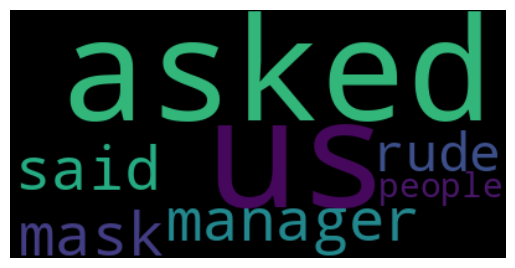

In [ ]:
# For only the 5th topic, plot its word cloud

# For each topic indice get the word
word_topic = topicIndices.rdd.map(lambda row: [vocabList[i] for i in row.termIndices]).collect()
from wordcloud import WordCloud
# Generate the word cloud for the 2nd topic
wordcloud = WordCloud().generate(" ".join(word_topic[5]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Getting reviews with most dominant topic being topic 5

In [ ]:
from pyspark.sql.types import IntegerType


# Correct UDF for dominant topic
def get_dominant_topic(vector):
    return int(np.argmax(vector.toArray()))

get_topic_udf = udf(get_dominant_topic, IntegerType())

# Add dominant topic column
lda_with_topic = lda_result_df_post.withColumn("dominant_topic", get_topic_udf("topicDistribution"))

# Filter reviews where Topic 5 is dominant
covid_reviews = lda_with_topic.filter(col("dominant_topic") == 5)

# Show reviews from Topic 5
covid_reviews.select("text_","customer_stars").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
lda_with_topic.show()

+--------------------+--------------------+--------------------+------+-------------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|         business_id|                name|             address|state_|         city|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|             Reviews|     cleaned_reviews|               words| filtered_words_post|        raw_features|            features|   topicDistribution|dominant_topic|
+--------------------+--------------------+-------

In [ ]:
# Group by dominant topic and count number of reviews per topic
topic_frequencies = lda_with_topic.groupBy(col("dominant_topic")).agg(count("*").alias("review_count"))

# Sort by frequency (optional)
topic_frequencies = topic_frequencies.orderBy("review_count", ascending=False)

# Show results
topic_frequencies.show()

+--------------+------------+
|dominant_topic|review_count|
+--------------+------------+
|             2|       52613|
|             5|       34188|
|            16|       26547|
|            18|       26263|
|             7|       25212|
|             1|       23730|
|            14|       23410|
|            10|       18689|
|            15|       18534|
|            13|       14893|
|             3|       14155|
|             0|       13961|
|             4|       13455|
|            12|       13389|
|            17|       12267|
|            11|       11811|
|             6|        7832|
|             8|        7175|
|            19|        5508|
|             9|        4561|
+--------------+------------+



Most reviews Post Covid are from topic 2 and 5. Topic 2 is about positive experiences emphasizing loyal customers and friendly service. Topic 5 is probably about COVID Protocol Complaints of customers. (masks, asked, manager)

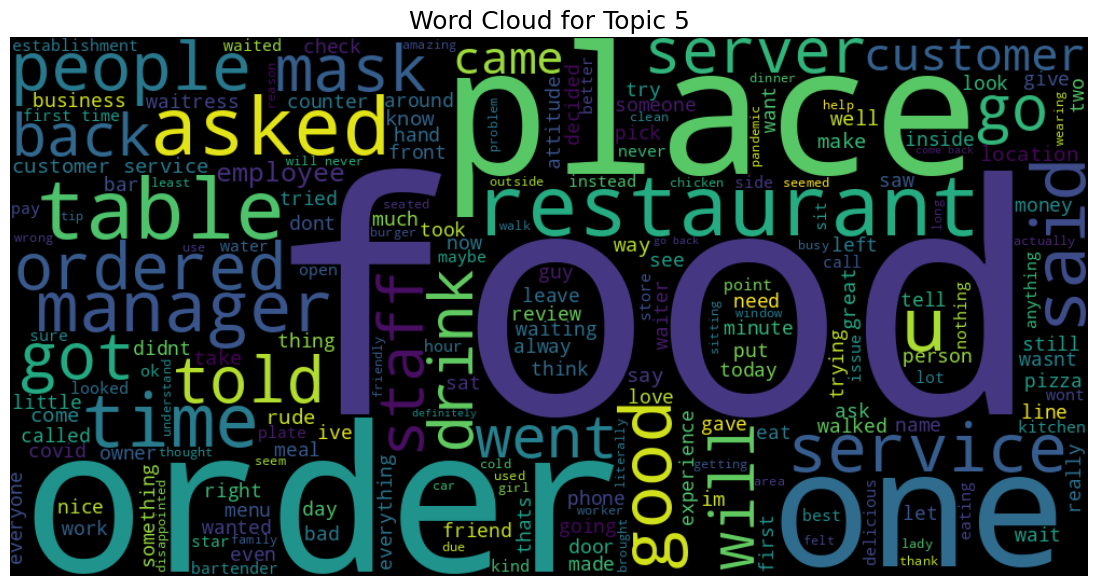

In [ ]:
# PySpark & Python Word Cloud
from wordcloud import WordCloud

# Step 1: Filter for Topic 5
topic5_reviews = lda_with_topic.filter(lda_with_topic["dominant_topic"] == 5)

# Step 2: Collect review text to the driver
topic5_texts = topic5_reviews.select("Reviews").rdd.flatMap(lambda x: x).collect()

# Step 3: Join all reviews into one text blob
text_combined = " ".join(topic5_texts)

# Step 4: Generate and show word cloud
wordcloud = WordCloud(width=1000, height=500).generate(text_combined)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Topic 5", fontsize=18)
plt.show()


Words like covid, mask, pandemic, clean
and words with negative sentiment like 'disappointed' and 'rude'.

#### Topic Detection for Pre Covid Reviews

In [ ]:
# create a CountVectorizer, fit & transform
cv_pre = CountVectorizer(inputCol="filtered_words_pre", outputCol="raw_features", vocabSize=10000)
cv_model_pre = cv_pre.fit(filtered_precov_df)
result_cv_pre = cv_model_pre.transform(filtered_precov_df)
# create IDF, fit & transform
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv_pre)
result_tfidf = idfModel.transform(result_cv_pre)

# Let's train our LDA model
lda = LDA(k=20, maxIter=100, optimizer="em", featuresCol="features", seed=42)
lda_mode_pre = lda.fit(result_tfidf)
lda_result_df_pre = lda_mode_pre.transform(result_tfidf)

In [ ]:
topicIndices = lda_mode_pre.describeTopics(maxTermsPerTopic = 8)
vocabList = cv_model_pre.vocabulary

# we print the final topics
for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")


Topic ID:0
lobster

seafood
delicious
mac
oysters
duck
wrap
------------------
Topic ID:1

cheap
quick
authentic
clean
quality
food
neighborhood
------------------
Topic ID:2
sandwich
pork
chicken
salad
wings
fast
fries
sauce
------------------
Topic ID:3
us
minutes
table
told
order
asked

took
------------------
Topic ID:4
kids

guy
buffet
guys
store
money
one
------------------
Topic ID:5
tacos
taco
mexican
chips

salsa
beans
burrito
------------------
Topic ID:6
breakfast
brunch
eggs
toast
french
bacon
egg
cake
------------------
Topic ID:7
sushi
amazing
recommend
roll
rolls
excellent
highly
fantastic
------------------
Topic ID:8
pizza
cream
ice
pie
crust
chocolate
cheese
pizzas
------------------
Topic ID:9
thai

donuts
pad
pretty
fried
always
grits
------------------
Topic ID:10

friendly
stop
park
orlando
place
stopped
gem
------------------
Topic ID:11
bar
beer
drinks
happy
drink
beers
selection
patio
------------------
Topic ID:12
steak

birthday
husband
appetizer
dinner
cooke

Pre-COVID Review Topics Summary
Restaurant reviews before COVID-19 focused on a wide range of dining experiences and food quality, with common themes including:
Diverse Cuisine, Family & Group Dining, Service & Speed

General Affection: Many reviews included warm, loyal sentiments like “love this place” or “hidden gem.”

Post-COVID Review Topics Summary
Post-COVID reviews reflect shifts in dining behavior, emerging challenges, and new customer priorities:

Pandemic-Specific Frustrations: New topics appeared around mask policies, rude interactions, and conflicts with staff, driven by COVID restrictions.

Outdoor & Contactless Dining: Increased mentions of outdoor patios, seating, pickup, and delivery.

Support for Local Businesses: Many reviews express desire to support community restaurants and local establishments.

Portion Sizes & Pricing

Positive Sentiment Persists: Despite challenges, many reviews still emphasized great service, friendly staff, and amazing experiences.

## Closed Restaurants (Enxrw an to theloume eje dixnei jj kati)

In [ ]:
closed_restaurants = filtered_postcov_df.filter(col("is_open") == 0)
closed_restaurants.show()

+--------------------+--------------------+--------------------+------+-----------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|state_|       city|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|             Reviews|     cleaned_reviews|               words| filtered_words_post|
+--------------------+--------------------+--------------------+------+-----------+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+----------------

<ipython-input-46-052d6337a6b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stars',y = "count", data=df_closed_stars, palette='viridis')


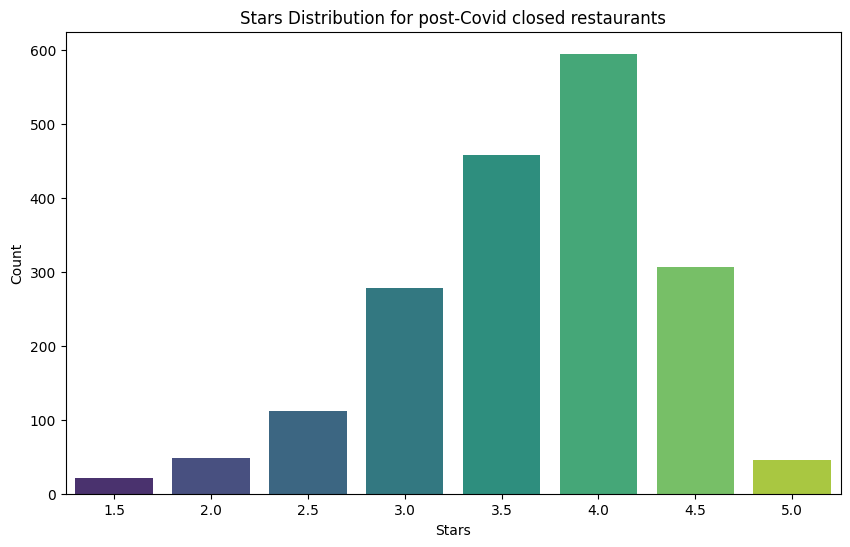

In [ ]:
closed_stars = closed_restaurants.groupBy("stars").agg(countDistinct("business_id").alias("count"))

# Convert the DataFrame to a Pandas DataFrame

df_closed_stars=closed_stars.toPandas()

plt.figure(figsize=(10,6))
# Plot : Distribution of stars from post_df
sns.barplot(x='stars',y = "count", data=df_closed_stars, palette='viridis')
plt.title("Stars Distribution for post-Covid closed restaurants")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

Reviews of Closed Restaurants

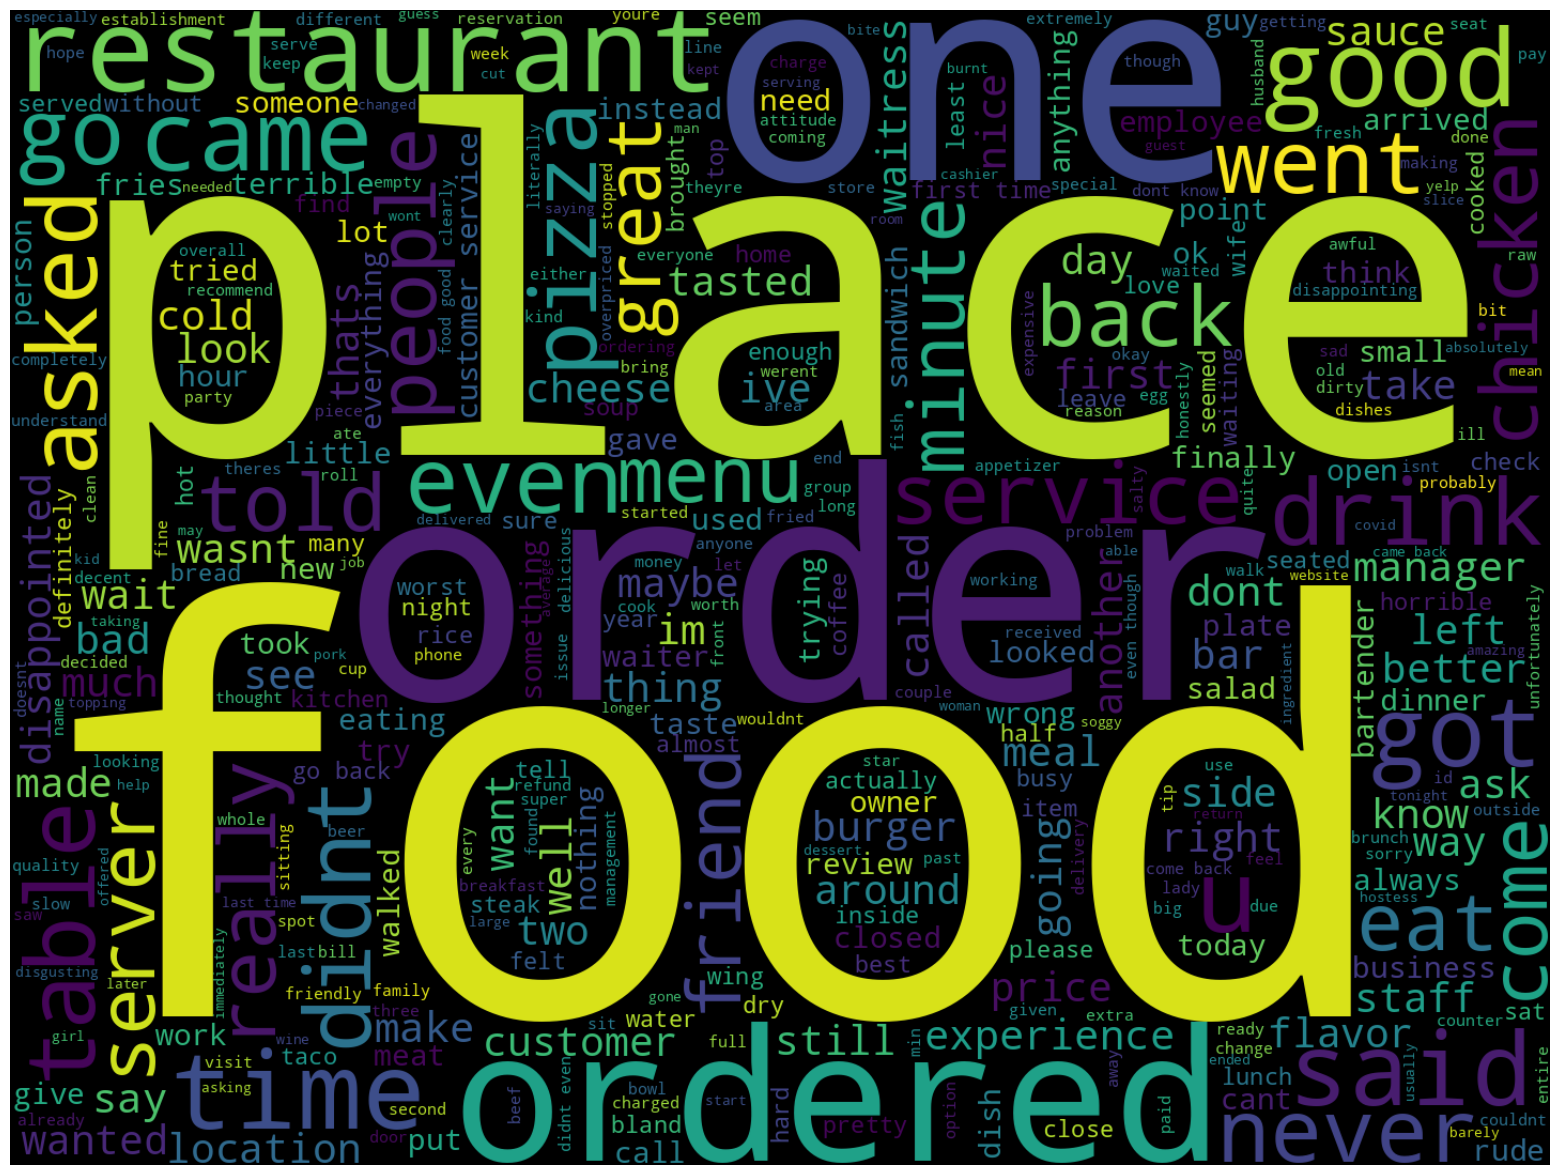

In [ ]:
# reviews of closed restaurants
# Convert Spark DataFrame to Pandas (collecting only the text column)
closed_restaurants_negative = closed_restaurants.filter(col('customer_stars')<= 2)
text_data_closed = ' '.join([item for sublist in closed_restaurants_negative.select("filtered_words_post").rdd.flatMap(lambda x: x).collect() for item in sublist])

# Generate the word cloud
cloud_post = WordCloud(width=1440, height=1080, max_words=400).generate(text_data_closed)

# Display the word cloud
plt.figure(figsize=(20, 15))
plt.imshow(cloud_post, interpolation="bilinear")
plt.axis('off')
plt.show()

Check how many restaurants closed in each state

<ipython-input-48-b5b0aa5f342e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="state_", y = "count" , data = closed_by_location.toPandas(),palette = "viridis")


Text(0.5, 0, 'state')

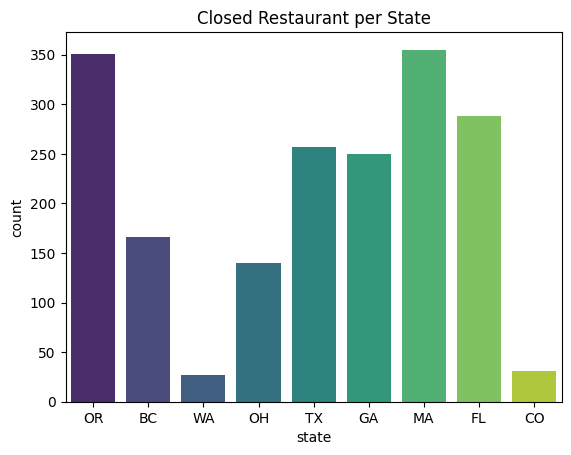

In [ ]:
closed_by_location = closed_restaurants.groupBy("state_").agg(countDistinct("business_id").alias("count"))
sns.barplot(x="state_", y = "count" , data = closed_by_location.toPandas(),palette = "viridis")
plt.title("Closed Restaurant per State")
plt.xlabel("state")

Categories with most closed restaurants

In [ ]:
# Explode category strings into arrays
category_df = closed_restaurants.withColumn("category", explode(split("categories", ", ")))

category_df.groupBy("category").agg(countDistinct("business_id").alias("count")).orderBy(col("count").desc()).show(15)

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants| 1865|
|                Food|  638|
|           Nightlife|  476|
|                Bars|  456|
|American (Traditi...|  309|
|          Sandwiches|  307|
|  Breakfast & Brunch|  294|
|      American (New)|  285|
|               Pizza|  200|
|             Burgers|  183|
|        Coffee & Tea|  177|
|               Salad|  156|
|             Italian|  150|
|             Seafood|  150|
|             Mexican|  136|
+--------------------+-----+
only showing top 15 rows



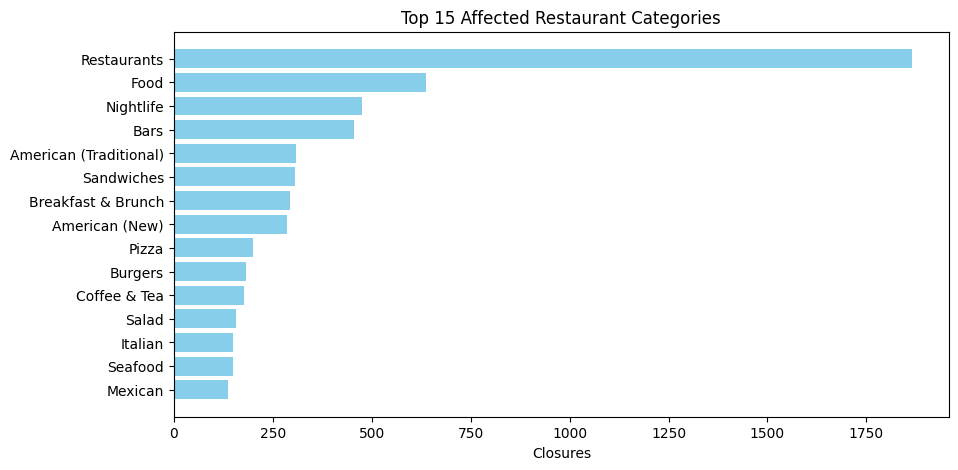

In [ ]:
top_categories_pd = category_df.groupBy("category").agg(countDistinct("business_id").alias("count")).orderBy(col("count").desc()).limit(15).toPandas()

plt.figure(figsize=(10, 5))
plt.barh(top_categories_pd['category'], top_categories_pd['count'], color='skyblue')
plt.title('Top 15 Affected Restaurant Categories')
plt.xlabel('Closures')
plt.gca().invert_yaxis()
plt.show()

## Sentiment Overtime

Getting the Reviews from 2018-2020

In [ ]:
pre_df_2018 = pre_df.where(col("date_") > "2018-01-01")

Classifying the reviews as negative, positive and neutral using the customer stars

In [ ]:
pre_df_2018 = pre_df_2018.withColumn(
    "customer_stars_category",
    when(col("customer_stars").isin([4, 5]), "positive")
    .when(col("customer_stars").isin([1, 2]), "negative")
    .otherwise("neutral")
)
post_df_sentiment = post_df.withColumn(
    "customer_stars_category",
    when(col("customer_stars").isin([4, 5]), "positive")
    .when(col("customer_stars").isin([1, 2]), "negative")
    .otherwise("neutral")
)

In [ ]:
# changing the date column to Month-Year format
post_df_sentiment = post_df_sentiment.withColumn("date_", to_date(col("date_"))) \
                        .withColumn("year_month", date_format(col("date_"), "yyyy-MM"))

pre_df_2018 = pre_df_2018.withColumn("date_", to_date(col("date_"))) \
                        .withColumn("year_month", date_format(col("date_"), "yyyy-MM"))

Sentiment counts per month and year

In [ ]:
# Creating the sentiment counts by month year and displaying them for post dataset
sentiment_counts_by_month_year_post = post_df_sentiment.groupBy("year_month", "customer_stars_category").count().orderBy("year_month")
sentiment_counts_by_month_year_post.show()

+----------+-----------------------+-----+
|year_month|customer_stars_category|count|
+----------+-----------------------+-----+
|   2020-01|                neutral| 1892|
|   2020-01|               positive|12504|
|   2020-01|               negative| 3724|
|   2020-02|               positive|33529|
|   2020-02|               negative|10592|
|   2020-02|                neutral| 5061|
|   2020-03|               positive|21850|
|   2020-03|                neutral| 2872|
|   2020-03|               negative| 6261|
|   2020-04|               negative| 3117|
|   2020-04|                neutral|  924|
|   2020-04|               positive| 9648|
|   2020-05|                neutral| 1409|
|   2020-05|               negative| 4635|
|   2020-05|               positive|13463|
|   2020-06|               positive|17690|
|   2020-06|                neutral| 1883|
|   2020-06|               negative| 5759|
|   2020-07|               negative| 6521|
|   2020-07|                neutral| 2310|
+----------

In [ ]:
# Creating the sentiment counts by month year and displaying them for pre dataset
sentiment_counts_by_month_year_pre = pre_df_2018.groupBy("year_month", "customer_stars_category").count().orderBy("year_month")
sentiment_counts_by_month_year_pre.show()

+----------+-----------------------+-----+
|year_month|customer_stars_category|count|
+----------+-----------------------+-----+
|   2018-01|               positive|37844|
|   2018-01|                neutral| 6298|
|   2018-01|               negative|11191|
|   2018-02|               negative|10802|
|   2018-02|                neutral| 5886|
|   2018-02|               positive|35491|
|   2018-03|               negative|13052|
|   2018-03|               positive|41955|
|   2018-03|                neutral| 6762|
|   2018-04|               negative|12790|
|   2018-04|               positive|41575|
|   2018-04|                neutral| 6730|
|   2018-05|               positive|40903|
|   2018-05|                neutral| 6655|
|   2018-05|               negative|13149|
|   2018-06|                neutral| 6789|
|   2018-06|               negative|13115|
|   2018-06|               positive|42370|
|   2018-07|               negative|14350|
|   2018-07|                neutral| 7419|
+----------

Joining the two dataframes to create a lineplot

In [ ]:
sentiment_over_time = sentiment_counts_by_month_year_pre.union(sentiment_counts_by_month_year_post)

In [ ]:
# Pivot the data and aggregate the count for each category
pivoted_sentiment = sentiment_over_time.groupBy("year_month") \
    .pivot("customer_stars_category", ["positive", "negative", "neutral"]) \
    .agg({"count": "sum"})  # Aggregating by summing the count for each category

pivoted_sentiment = pivoted_sentiment.orderBy("year_month", ascending = True)
# Show the pivoted result
pivoted_sentiment.show()

+----------+--------+--------+-------+
|year_month|positive|negative|neutral|
+----------+--------+--------+-------+
|   2018-01|   37844|   11191|   6298|
|   2018-02|   35491|   10802|   5886|
|   2018-03|   41955|   13052|   6762|
|   2018-04|   41575|   12790|   6730|
|   2018-05|   40903|   13149|   6655|
|   2018-06|   42370|   13115|   6789|
|   2018-07|   47901|   14350|   7419|
|   2018-08|   43290|   13524|   6970|
|   2018-09|   37654|   12183|   5971|
|   2018-10|   36825|   11814|   5756|
|   2018-11|   33682|   10857|   5245|
|   2018-12|   35281|   11946|   5595|
|   2019-01|   38979|   11302|   5911|
|   2019-02|   35591|   11538|   5528|
|   2019-03|   41175|   13477|   6278|
|   2019-04|   37130|   12242|   5579|
|   2019-05|   39515|   13226|   6067|
|   2019-06|   40479|   13427|   6125|
|   2019-07|   41932|   13488|   6380|
|   2019-08|   40919|   13073|   6159|
+----------+--------+--------+-------+
only showing top 20 rows



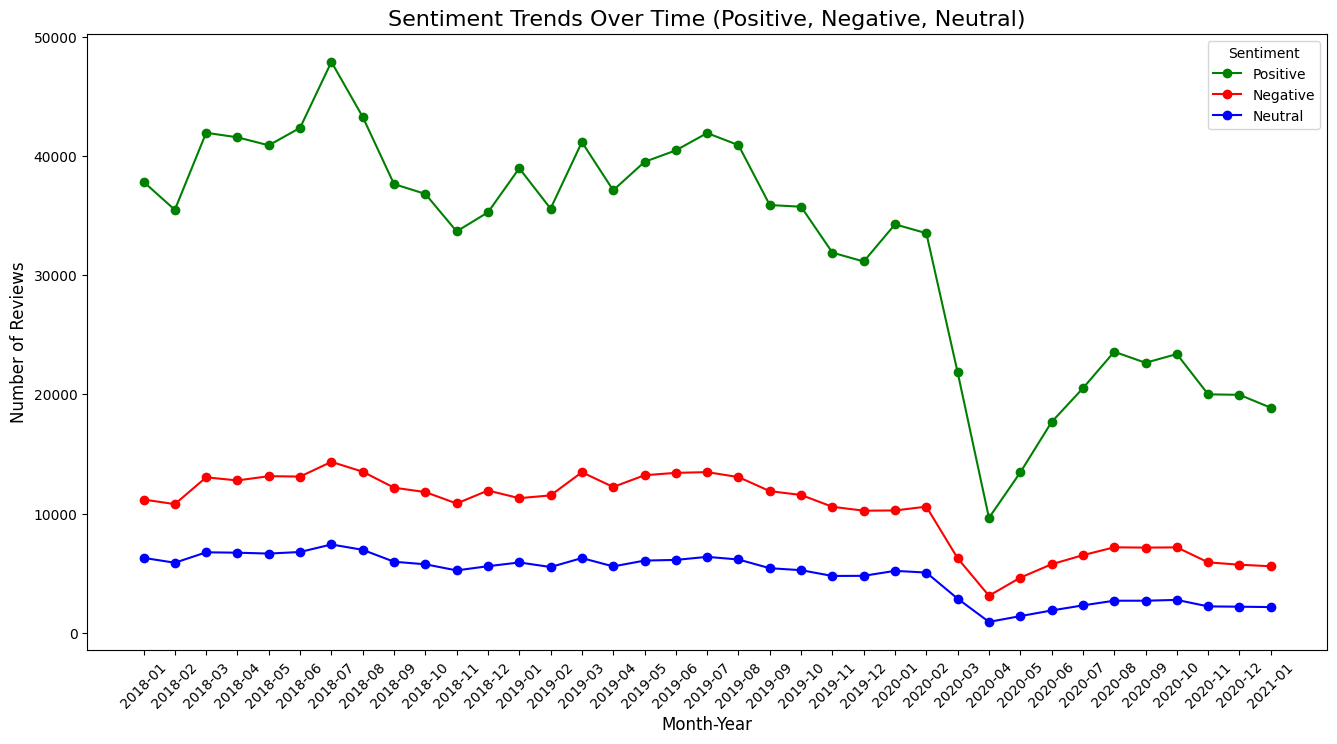

In [ ]:
# Convert the pivoted PySpark DataFrame to Pandas for plotting
pivoted_sentiment_pd = pivoted_sentiment.toPandas()

plt.figure(figsize=(16, 8))
# Plot each sentiment category as a line
plt.plot(pivoted_sentiment_pd['year_month'], pivoted_sentiment_pd['positive'], marker='o', linestyle='-', color='g', label='Positive')
plt.plot(pivoted_sentiment_pd['year_month'], pivoted_sentiment_pd['negative'], marker='o', linestyle='-', color='r', label='Negative')
plt.plot(pivoted_sentiment_pd['year_month'], pivoted_sentiment_pd['neutral'], marker='o', linestyle='-', color='b', label='Neutral')

# Add titles and labels
plt.title('Sentiment Trends Over Time (Positive, Negative, Neutral)', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-a
plt.legend(title='Sentiment')
plt.show()

An over all time analysis based on number of reviews is shown in the line chart above. Specifically, it shows the sentiment trends in restaurant reviews from January 2018 to January 2021. It's obvious that positive reviews consistently dominated over time but dropped sharply around March 2020, aligning with the start of the Covid-19 pandemic.

 Also, the negative and neutral reviews declined too during this period, but to a lesser extent. While the volume of reviews seems to gradually recovered in the months that followed, the positive reviews remained lower than pre-pandemic levels, suggesting a lasting impact on customer satisfaction and engagement during the Covid period.

## Recommendation System Post-Covid

In [ ]:
# Index the `user_id` and `business_id` columns to take numerical values
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index", handleInvalid="keep")
business_indexer = StringIndexer(inputCol="business_id", outputCol="business_index", handleInvalid="keep")

# Fit and transform to get indexed columns
df_indexed = user_indexer.fit(post_df).transform(post_df)
df_indexed = business_indexer.fit(df_indexed).transform(df_indexed)

#  Check the schema after indexing to ensure proper data types
df_indexed.printSchema()

# Prepare data for ALS (Use indexed columns for user and business)
df_clean = df_indexed.select("user_index", "business_index", "customer_stars")

#  Split the data into training and test sets
(training_data, test_data) = df_clean.randomSplit([0.8, 0.2], seed=1234)

# Train the ALS model
als = ALS(maxIter=10, regParam=0.01, userCol="user_index", itemCol="business_index",
          ratingCol="customer_stars", coldStartStrategy="drop")

# Fit the model to the training data
model = als.fit(training_data)

#  Generate recommendations for all users
user_recs = model.recommendForAllUsers(10)

# Explode recommendations and select relevant columns
user_recs = user_recs.selectExpr("user_index", "explode(recommendations) as recommendations")
user_recs = user_recs.selectExpr("user_index", "recommendations.business_index as business_index",
                                 "recommendations.rating as rating")

# Show the results
user_recs.show()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: timestamp (nullable = true)
 |-- user_index: double (nullable = false)
 |-- business_index: double (nullable = false)

+----------+--------------+---------+
|user_index|business_index|   r

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="customer_stars",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 4.630618845883565


RMSE of the reccomendation model is approximately 4.63.

This indicates that, on average, the predicted star ratings differ from the actual user ratings by about 4.63 stars.

Showing Recommendations for a user

In [ ]:
# Specify the user_id for whom you want to show recommendations
user_index = 2

# Show the businesses rated by the user
print(f"Businesses rated by user with index {user_index}")

# Get the ratings for the user
user_ratings = df_indexed.filter(df_indexed.user_index == user_index)\
    .select("name", "categories", "customer_stars")

# Show the ratings (businesses) by the user
user_ratings.show(50, truncate=False)

# Show the top 10 recommendations for the specific user
user_rec = user_recs.filter(user_recs.user_index == user_index)

# Print and show the recommendations
print(f"Top 10 recommendations for user with index {user_index}")
user_rec.show(truncate=False)

Businesses rated by user with index 2
+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|name                                 |categories                                                                                                                                  |customer_stars|
+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|Taco Bell                            |Tex-Mex, Fast Food, Restaurants, Mexican                                                                                                    |5             |
|Tijuana Flats                        |Mexican, Tex-Mex, Restaurants                                                                                                              

As we can see above, user with index 2 rated a variety of restauraunts, showing a strong preference for casual dining, fast food, and international cuisine (e.g., Mexican, American, Italian, Thai, and British).

In [ ]:
# Filter only necessary columns from df_indexed
business_details = df_indexed.select("business_index", "name", "categories").dropDuplicates(["business_index"])

# Join recommendations with business details
recs_with_details = user_rec.join(business_details, on="business_index", how="left")

# Show top 10 results
recs_with_details.select( "name", "rating","categories").show(truncate=False)

+------------------------------+---------+-------------------------------------------------------------------------------------------------+
|name                          |rating   |categories                                                                                       |
+------------------------------+---------+-------------------------------------------------------------------------------------------------+
|Mashita Teriyaki              |9.970569 |Restaurants, Chinese, Japanese, Korean                                                           |
|Saint Burrito                 |9.742654 |Food Trucks, Restaurants, Mexican, Food, New Mexican Cuisine, Food Stands, Vegetarian            |
|Café Margaux                  |10.329615|Seafood, French, Steakhouses, Restaurants                                                        |
|Kasbah Moroccan Cafe          |9.697814 |Cafes, Restaurants, African, Mediterranean, Food, Tea Rooms, Delis, Vegetarian, Moroccan         |
|The Coffee S

 Above are reulted the recommend restaurants for user with index 2.

 The top suggestions, like Café Margaux, Mashita Teriyaki, and Kiku Curry, all have high predicted ratings above 9. These places offer a mix of cuisines such as Japanese, Thai, Mexican, and French, which match the user’s past preferences for casual and international food.
 Based on all this the model suggests new spots the user would likely enjoy.

# Classification Modelling on Reviews column

We are going to perform sentiment analysis, through Logistic Regression, in order to predict the category at which each review of each customer falls.
1. We will first create a new columns that will be our label. This column will be called "customer_stars_category" and will be generated by the "customer_stars" as follows:
- if "customer_star" == 4 OR 5 => "customer_stars_category" == "Positive"
- if "customer_star" == 3 => "customer_stars_category" == "Neutral"
- if "customer_star" == 1 OR 2 => "customer_stars_category" == "Negative"

2. Then, we will filter out all the reviews that are not in English language.

3. The next step will be a preprocessing step of the "Reviews" column. We will do TF-IDF in order to measure the importance of each word in the reviews collection. We will start by tokenizing the text and removing stopwords. After we will create a CountVectorizer, fit & transform. This will allows us to convert text data into a numerical format snce it will generate a matrix of term frequency counts for each review. Finally, we will use IDF to weight the word frequencies.

4. Afterwards, we will continue with more pre-processing steps in other columns:
  - Changing to the correct province (Vancouver is in BC not ABE).
  - One-hot-encoding at the states column.

5. Then, we split the dataset in train(80%) and test(20%) datasets.

6. Then, we create the VectorAssembler that includes all the features that we will use to train the Logistic Regression model and label encode the label, "customer_stars_category" on train data.

7. Train anf fit Logistic Regression on train data.\
   *Note: we set elastic net regularization to 1. This way we use Lasso - L1 regularization, which it basically automatically performs feature selection by setting some feature coefficients to zero. Features with non-zero coefficients are the ones that the model has learned to be important for predicting the target variable.*

8. Create VectorAssembler for test data and label encode the label, "customer_stars_category" on test data.


9. Make predictions

10. Calculate metrics


*Note: The above process will be performed at a random sample of 10% of the pre-covid dataset*

In [ ]:
"""
First we start by taking a proportion of our dataset - we take the 10%
"""

sampled_pre_df3 = pre_df.sample(fraction=0.1, seed=42)

In [ ]:
"""
Printing schema of my sampled_pre_df dataset and shoe the first 5 cols
"""
sampled_pre_df3.printSchema()
#sampled_pre_df3.show(5)

In [ ]:
"""
1)
"""
"""
Creating a new column named "customer_stars_category" and categorizing customer_stars column as it follows: 1,2 => negative, 3 => neutral, 4,5 => positive
Then, cout how much i have from each category.
"""
from pyspark.sql.functions import when, col

sampled_pre_df3 = sampled_pre_df3.withColumn(
    "customer_stars_category",
    when(col("customer_stars").isin([4, 5]), "positive")
    .when(col("customer_stars").isin([1, 2]), "negative")
    .otherwise("neutral")
)

sampled_pre_df3.show(20, truncate=False)
sampled_pre_df3.groupBy("customer_stars_category").count().show()

In [ ]:
!pip install langdetect

In [ ]:
"""
2)
"""
"""
Filter out all non-Enlgish reviews from the "text_" columns
"""
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from langdetect import detect, DetectorFactory
import langdetect

# Set seed for consistent results
DetectorFactory.seed = 42

# Define UDF to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

detect_language_udf = udf(detect_language, StringType())

# Apply UDF to create a new column for language
sampled_pre_df3 = sampled_pre_df3.withColumn("language", detect_language_udf(sampled_pre_df3["text_"]))

# Filter the DataFrame to only include English-language reviews
sampled_pre_df3 = sampled_pre_df3.filter(sampled_pre_df3["language"] == "en")


# Show rows where the text is not English
#sampled_pre_df_with_sentiment.filter(sampled_pre_df_with_sentiment["language"] != "en").select("text_", "language").show()

In [ ]:
#sampled_pre_df3.show(10)

In [ ]:
"""
3) A)
"""
"""
We preprocess the review column ("text_") (1)
"""
"""
starting by tokenize and remove stop words from the reviews column
"""
sampled_pre_df_dataset_filtered3 = sampled_pre_df3.dropna() #filtering out NAs
tokenizer2 = RegexTokenizer(inputCol="text_", outputCol="words", pattern="\\W")

tokenized_raw3 = tokenizer2.transform(sampled_pre_df_dataset_filtered3)
print("--- tokenized reviews ---")
tokenized_raw3.select("words").show(5)

remover3 = StopWordsRemover(inputCol="words", outputCol="filtered")
df_cleaned3 = remover3.transform(tokenized_raw3)
print("--- remove stop words from reviews ---")
df_cleaned3.select("filtered").show(5)

In [ ]:
"""
3) B)
"""
"""
Now, we create a CountVectorizer, fit & transform
This will allows us to convert text data into a numerical format.
It will generate a matrix of term frequency counts for each review
"""
"""
For CountVectorizer we use as input the column that was the output from the StopWordsRemover. In addition, set vocabSize=5000, minDF=10.0
"""
from pyspark.ml.feature import CountVectorizer

cv3 = CountVectorizer(inputCol="filtered", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel3 = cv3.fit(df_cleaned3)
result_cv3 = cvmodel3.transform(df_cleaned3)
#result_cv3.show(5)

In [ ]:
"""
3) C)
"""
"""
Continue with preprocess of Reviews column (3)
Here, we use IDF to weight the word frequencies.
"""
idf3 = IDF(inputCol="raw_features", outputCol="reviews")
idfModel3 = idf3.fit(result_cv3)
result_tfidf3 = idfModel3.transform(result_cv3)
#result_tfidf3.show(5)

In [ ]:
"""
4) A)
"""
"""
Changing to the correct province
"""
result_tfidf3=result_tfidf3.withColumn("state_",
                          when((col("state_") == "ABE") & (col("city") == "Vancouver"), "BC")
    .otherwise(col("state_"))
)

In [ ]:
"""
4) B)
"""
"""
state_: Apply one-hot encoding at the "states" column
"""
from pyspark.ml.feature import OneHotEncoder
states = [("MN",), ("OR",), ("KY",), ("BC",), ("NH",), ("WA",), ("OH",), ("TX",),("GA",), ("MA",), ("KS",), ("FL",), ("CO",)]
states_df = spark.createDataFrame(states, ["state_"])

states_indexer = StringIndexer(inputCol="state_", outputCol="state_index")

states_encoder = OneHotEncoder(inputCol="state_index", outputCol="state_ohe")

pipeline = Pipeline(stages=[states_indexer, states_encoder])

pipeline_model = pipeline.fit(states_df)
df_encoded = pipeline_model.transform(states_df)
result_tfidf3 = result_tfidf3.join(
    df_encoded.select("state_", "state_index", "state_ohe"),
    on="state_",
    how="left"
)

In [ ]:
"""
5)
"""
"""
We split to train and test
"""
train_data, test_data = result_tfidf3.randomSplit([0.8, 0.2], seed=42)

In [ ]:
"""
6)
"""
"""
We create the VectorAssembler that includes all the features on train data
"""
assembler_lr = VectorAssembler(
    inputCols=["latitude","longitude","useful","funny","cool","review_count","stars", "state_ohe", "is_open","reviews"],
    outputCol="all_features"
)
df_final_train = assembler_lr.transform(train_data)

In [ ]:
#df_final_train.show(5)

In [ ]:
#Label Encoding the "customer_stars_category"
df_final_train = df_final_train.withColumn(
    "customer_stars_category_labeled",when((col("customer_stars_category") == "positive"), 0).when((col("customer_stars_category") == "neutral"), 1).otherwise(2)
)

In [ ]:
"""
7)
"""
"""
Perform logistic regression
"""
#Train logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=15,regParam=0.03,elasticNetParam=1,featuresCol="all_features", labelCol="customer_stars_category_labeled")
lr_model = lr.fit(df_final_train)

In [ ]:
"""
8)
"""
"""
We create the VectorAssembler that includes all the features on test data
"""
assembler_lr_test = VectorAssembler(
    inputCols=["latitude","longitude","useful","funny","cool","review_count","stars", "state_ohe", "is_open","reviews"],
    outputCol="all_features"
)
df_final_test = assembler_lr_test.transform(test_data)

In [ ]:
df_final_test = df_final_test.withColumn(
    "customer_stars_category_labeled",when((col("customer_stars_category") == "positive"), 0).when((col("customer_stars_category") == "neutral"), 1).otherwise(2)
)

In [ ]:
"""
9)
"""
"""
Make predictions
"""

predictions = lr_model.transform(df_final_test)
predictions.select("customer_stars_category_labeled", "prediction").show(10)

In [ ]:
"""
10)
"""
"""
Calculate metrics
"""
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="customer_stars_category_labeled",
                                              predictionCol="prediction",
                                              metricName="f1")

f1_score = evaluator.evaluate(predictions)

print(f"Test F1-score: {f1_score}")